<a href="https://colab.research.google.com/github/rajy4683/S15Test/blob/master/S15Unet_Expand_Full.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Fri May 22 14:36:52 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import sys

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
sys.path.append('/content/drive/My Drive/EVA4/RekogNizer')
sys.path.append('/content/drive/My Drive/EVA4')
sys.path.append('/content/drive/My Drive/EVA4/DenseDepth')

### Dependencies


In [0]:
!pip install -r /content/drive/My\ Drive/EVA4/RekogNizer/requirements.txt

In [0]:
!pip install -U git+https://github.com/albu/albumentations

In [6]:
!wandb login a6f947d2d2f69e7a8c8ca0f69811fd554f27d204


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
Successfully logged in to Weights & Biases!


In [0]:
import os

import numpy as np
import cv2
from matplotlib import pyplot as plt
from skimage.color import label2rgb

import albumentations as A
import random
from google.colab.patches import cv2_imshow
from PIL import Image
import glob
import pandas as pd

import torch
from zipfile import ZipFile
import re
import h5py
import time



In [8]:
%load_ext autoreload
%autoreload 2
import torch
import torchvision
import torchvision.transforms as transforms
from RekogNizer import hyperparams


from albumentations import Compose, RandomCrop, Normalize, HorizontalFlip, Resize, Cutout, MotionBlur
from albumentations import (
    HorizontalFlip, Compose, RandomCrop, Cutout,Normalize, HorizontalFlip, RandomBrightnessContrast,
    Resize,RandomSizedCrop, MotionBlur,MultiplicativeNoise,InvertImg, IAAFliplr,
	IAAPerspective,
)
from albumentations.pytorch import ToTensor
import random

from torchvision.datasets.vision import VisionDataset
from torchvision.datasets.utils import check_integrity, download_and_extract_archive
import os
import sys
import numpy as np
from torchvision import datasets
#from RekogNizer import imgnetloader
from RekogNizer import basemodelclass
from RekogNizer import mmdlrfinder

from RekogNizer import mmdtraintest
from RekogNizer import mmddataloader
from RekogNizer import mmdlosses
from RekogNizer import mmdmodels

from RekogNizer import hyperparams
from RekogNizer import fileutils

from torch.utils.data import Dataset
import shutil
from tqdm import tqdm
from RekogNizer import mmdmodels

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, OneCycleLR, MultiStepLR, CyclicLR, ReduceLROnPlateau


import kornia

import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
import wandb

  pip install torch-lr-finder -v --global-option="amp"
  pip install torch-lr-finder -v --global-option="amp"


### Mask Image (Mean and Variance
Mask Mean:0.057950844077600344, Mask StdDev:0.0016620444341229432
### Depth mean and Variance
Depth Mean:0.3679109312239146, Depth StdDev:0.03551773442719045

In [0]:
!rm -rf /content/train && mkdir -p /content/train
!rm -rf /content/test && mkdir -p /content/test

In [10]:
csv_file ='/content/drive/My Drive/EVA4/tsai/S15EVA4/FinalDataSet/DepthMapDataSetTrain.csv'
root_dir = '/content/drive/My Drive/EVA4/tsai/S15EVA4/'
batch_start = 120000
batch_end = batch_start+10000
dest_dir="/content/train"

mmddataloader.extract_data_files(csv_file, root_dir, batch_start,batch_end, dest_dir=dest_dir)


Extracting image and mask files


image_mask_gt8k12k.zip: 100%|██████████| 6948/6948 [02:13<00:00, 51.93it/s]


Extracting depth files


depth_mask_gt_8k12k.zip: 100%|██████████| 3474/3474 [01:54<00:00, 30.27it/s]


Extracting bg files
Total file count:30113 


### Dataloaders

In [0]:
size_hw = (224,224)
dest_dir="/content/train"
train_batch_size = 64
depth_dataset = mmddataloader.DepthMaskDataSet(csv_file, dest_dir, batch_start,batch_end, read_zip=False,
                                 transform_base=mmddataloader.resize_bg(size_hw[0],size_hw[1],[0.56632738, 0.51567622, 0.45670792], [0.1076622, 0.10650349, 0.12808967] ),
                                 transform_bg=mmddataloader.resize_bg(size_hw[0],size_hw[1],[0.57469445, 0.52241555, 0.45992244], [0.11322354, 0.11195428, 0.13441683]),
                                 transform_mask = mmddataloader.resize_bg_nonNorm(size_hw[0],size_hw[1]),
                                 transform_depth = mmddataloader.resize_bg_nonNorm(size_hw[0],size_hw[1]),
                                 transform_opt=mmddataloader.flip,
                                 #transform_mask=mmddataloader.resize_bg(size_hw[0],size_hw[1], [0.0579508], [0.001662]),
                                 #transform_depth=mmddataloader.resize_bg(size_hw[0],size_hw[1], [0.3679109], [0.03551773]),
                                 )
from torch.utils.data import DataLoader
kwargs= { 'num_workers':8,'pin_memory': True}
train_loader = DataLoader(depth_dataset, batch_size=train_batch_size, shuffle=False, **kwargs)

In [12]:
test_csv_file ='/content/drive/My Drive/EVA4/tsai/S15EVA4/FinalDataSet/DepthMapDataSetTest.csv'
root_dir = '/content/drive/My Drive/EVA4/tsai/S15EVA4/'
test_batch_start = 0
test_batch_end = test_batch_start + 5000
test_dest_dir = "/content/test"

mmddataloader.extract_data_files(test_csv_file, root_dir, test_batch_start,test_batch_end, dest_dir=test_dest_dir)

Extracting image and mask files


image_mask_gt1k2k.zip: 100%|██████████| 10002/10002 [00:34<00:00, 288.20it/s]


Extracting depth files


depth_mask_gt_1k2k.zip: 100%|██████████| 5001/5001 [01:04<00:00, 77.52it/s] 


Extracting bg files
Total file count:15020 


In [0]:
size_hw = (224,224)
test_dest_dir = "/content/test"
test_batch_size=32
test_dataset = mmddataloader.DepthMaskDataSet(test_csv_file, test_dest_dir, test_batch_start,test_batch_end,read_zip=False,
                                 transform_base=mmddataloader.resize_bg(size_hw[0],size_hw[1],[0.56632738, 0.51567622, 0.45670792], [0.1076622, 0.10650349, 0.12808967] ),
                                 transform_bg=mmddataloader.resize_bg(size_hw[0],size_hw[1],[0.57469445, 0.52241555, 0.45992244], [0.11322354, 0.11195428, 0.13441683]),
                                 transform_mask = mmddataloader.resize_bg_nonNorm(size_hw[0],size_hw[1]),
                                 transform_depth = mmddataloader.resize_bg_nonNorm(size_hw[0],size_hw[1]),
                                 #transform_mask=mmddataloader.resize_bg(size_hw[0],size_hw[1], [0.0579508], [0.001662]),
                                 #transform_depth=mmddataloader.resize_bg(size_hw[0],size_hw[1], [0.3679109], [0.03551773]),
                                 )
from torch.utils.data import DataLoader
kwargs= { 'num_workers':8,'pin_memory': True}
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, **kwargs)

In [0]:
# from RekogNizer import mmdbetamodels
# device = torch.device("cuda" if not hyperparams.hyperparameter_defaults['no_cuda'] else "cpu")
# model_new  =mmdmodels.UNet(n_channels=6, n_classes=2)

# expand_model_old  =mmdmodels.CustomUNet(model_new,n_channels=6, n_classes=2)
# expand_model_old = mmdtraintest.load_model_for_infer(expand_model_old, 
#                                   '/content/drive/My Drive/EVA4/model_saves/model-150cfeb3dc.h5',
#                                   device)
# new_expand_net = mmdbetamodels.ExpandUNet(expand_model_old, n_channels=6, n_classes=2)
# trainable_param_list = [param[1] for param in new_expand_net.named_parameters()][-18:]

In [0]:
from RekogNizer import mmdtraintest
from RekogNizer import mmdlosses

criterion={"mask":[mmdlosses.LocalBCELoss, mmdlosses.LocalSSIMLoss ], 
           "depth":[mmdlosses.LocalL1Loss, mmdlosses.LocalSSIMLoss]}

#criterion={"mask":[mmdlosses.dice_loss, mmdlosses.LocalBCELoss, mmdlosses.LocalSSIMLoss ], "depth":[mmdlosses.LocalRMSELoss]}
#model = basemodelclass.MonoMaskDepthResNetFunc()
optimizer=optim.SGD(trainable_param_list, lr=0.001,momentum=0.9,  weight_decay=0)
lrfinder = mmdtraintest.find_lr_type1(new_expand_net, optimizer, criterion, train_loader, testloader=None, seed=1, start_lr=0.0001, end_lr=1, step_mode="exp",num_iter=100)


0.02089296130854039 1.0 0.7839171886444092
{'lr': [0.00010964781961431851, 0.0001202264434617413, 0.0001318256738556407, 0.00014454397707459274, 0.00015848931924611136, 0.00017378008287493755, 0.00019054607179632473, 0.00020892961308540398, 0.00022908676527677731, 0.000251188643150958, 0.0002754228703338166, 0.00030199517204020164, 0.00033113112148259116, 0.0003630780547701014, 0.00039810717055349724, 0.00043651583224016605, 0.00047863009232263843, 0.0005248074602497726, 0.000575439937337157, 0.0006309573444801934, 0.0006918309709189364, 0.0007585775750291837, 0.0008317637711026711, 0.0009120108393559097, 0.001, 0.0010964781961431851, 0.0012022644346174132, 0.0013182567385564075, 0.0014454397707459273, 0.0015848931924611134, 0.0017378008287493754, 0.0019054607179632473, 0.00208929613085404, 0.0022908676527677737, 0.0025118864315095794, 0.0027542287033381664, 0.003019951720402016, 0.0033113112148259113, 0.0036307805477010144, 0.003981071705534973, 0.004365158322401658, 0.004786300923226

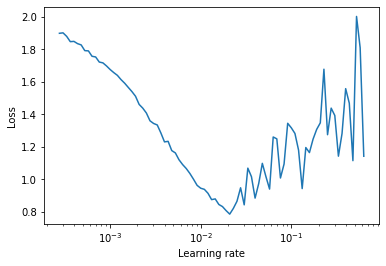

In [0]:
min_lr = lrfinder.history['lr'][np.argmin(lrfinder.history['loss'])]
max_lr = np.max(lrfinder.history['lr'])
print(min_lr, max_lr, np.min(lrfinder.history['loss']))
print(lrfinder.history)
lrfinder.plot()

In [0]:
summary(model_new, input_size=(6,64,64)  )

In [0]:
del model_new,expand_model
torch.cuda.empty_cache()

In [0]:
lrfinder.reset()

In [0]:
device = torch.device("cuda" if not hyperparams.hyperparameter_defaults['no_cuda'] else "cpu")
model_new  =mmdmodels.UNet(n_channels=6, n_classes=2)

# model_new = mmdtraintest.load_model_for_infer(model_new, 
#                                   '/content/drive/My Drive/EVA4/model_saves/model-d4f23f75a2.h5',
#                                   device)

# model_new = mmdtraintest.load_model_for_infer(model_new, 
#                                    '/content/drive/My Drive/EVA4/model_saves/model-23fcf0a1cf.h5',
#                                    device)
expand_model  =mmdmodels.CustomUNet(model_new,n_channels=6, n_classes=2)

In [0]:
expand_model = mmdtraintest.load_model_for_infer(expand_model, 
                                  '/content/drive/My Drive/EVA4/model_saves/model-15417da434.h5',
                                  device)
model_new_params = ['baseUNet.'+param[0] for param in list(model_new.named_parameters()) ]
expand_model_params = [param[1] for param in list(expand_model.named_parameters()) if param[0] not in model_new_params]

### Current Run

In [31]:
######## OCP 
from RekogNizer import mmdmodels
device = torch.device("cuda" if not hyperparams.hyperparameter_defaults['no_cuda'] else "cpu")
#tqdm._instances.clear()
hyperparams.set_hyperparam({"epochs":10})

hyperparams.hyperparameter_defaults['run_name'] = fileutils.rand_run_name()
hyperparams.hyperparameter_defaults['epochs'] = 40
hyperparams.hyperparameter_defaults['lr'] = 0.1
hyperparams.hyperparameter_defaults['ocp_max_lr'] = 0.1

print("Initializing datasets and dataloaders")    

#model_new =  mmdmodels.UNet(n_channels=6, n_classes=2)
wandb_run_init = wandb.init(config=hyperparams.hyperparameter_defaults, 
                            project=hyperparams.hyperparameter_defaults['project'])
#wandb.watch_called = False
config = wandb.config
print(config)
#wandb.watch(model_new, log="none")

# optimizer=optim.SGD(model_new.parameters(), lr=config.lr,momentum=config.momentum,
#                         weight_decay=0)
optimizer=optim.SGD(expand_model_params, lr=config.lr,momentum=config.momentum,
                        weight_decay=2e-5)
#expand_model_params
# criterion={"mask":[mmdlosses.dice_loss, mmdlosses.LocalBCELoss, mmdlosses.LocalPixelLoss], 
#            "depth":[mmdlosses.LocalRMSELoss, mmdlosses.LocalSSIMLoss]}

criterion={"mask":[mmdlosses.dice_loss, mmdlosses.LocalL1Loss], 
           "depth":[mmdlosses.LocalRMSELoss, mmdlosses.LocalSSIMLoss]}

#scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True, threshold=0.0001)
scheduler = OneCycleLR(optimizer, 
                        config.ocp_max_lr, 
                        epochs=config.epochs, 
                        cycle_momentum=True, 
                        steps_per_epoch=len(train_loader), 
                        base_momentum=config.momentum,
                        max_momentum=0.95, 
                        pct_start=0.208,
                        anneal_strategy=config.anneal_strategy,
                        div_factor=config.div_factor,
                        final_div_factor=config.final_div_factor
                           )

final_model_path = mmdtraintest.execute_model(expand_model, 
            hyperparams.hyperparameter_defaults, 
            train_loader, test_loader, 
            device, 
            wandb=wandb,
            optimizer_in=optimizer,
            scheduler=scheduler,
            prev_saved_model=None,
            criterion=criterion,
            save_best=True,
            lars_mode=False,
            batch_step=True)

Initializing datasets and dataloaders


  0%|          | 0/157 [00:00<?, ?it/s]

wandb_version: 1

_wandb:
  desc: null
  value:
    cli_version: 0.8.36
    framework: torch
    is_jupyter_run: true
    is_kaggle_kernel: false
    python_version: 3.6.9
anneal_strategy:
  desc: null
  value: linear
batch_size:
  desc: null
  value: 512
bias:
  desc: null
  value: false
cycle_momentum:
  desc: null
  value: false
div_factor:
  desc: null
  value: 128
dropout:
  desc: null
  value: 0.1
epochs:
  desc: null
  value: 40
factor:
  desc: null
  value: 0.0
final_div_factor:
  desc: null
  value: 64
lr:
  desc: null
  value: 0.1
lr_decay_threshold:
  desc: null
  value: 0.0
lr_policy:
  desc: null
  value: ocp
momentum:
  desc: null
  value: 0.9
no_cuda:
  desc: null
  value: false
ocp_max_lr:
  desc: null
  value: 0.1
pct_start:
  desc: null
  value: 0.208
project:
  desc: null
  value: news5
run_name:
  desc: null
  value: 15417da434
sched_lr_gamma:
  desc: null
  value: 0.5
sched_lr_step:
  desc: null
  value: 1
seed:
  desc: null
  value: 1
split_pct:
  desc: null
  val

loss=1.043799 m_loss=0.900700 d_loss=0.143099 batch_id=156: 100%|██████████| 157/157 [02:55<00:00,  1.12s/it]
loss=1.004236 m_loss=0.877510 d_loss=0.126725 batch_id=156: 100%|██████████| 157/157 [00:41<00:00,  3.78it/s]



Epoch: 1 Train set: Average loss: 1.062154, Mask loss:0.897599, Depth loss:0.164555, lr:0
Epoch: 1 Test set: Average loss: 0.998331, Mask loss:0.887770, Depth loss:0.110561
Model saved as Test loss reduced from  10000.0  to  0.9983310577975717


loss=1.071374 m_loss=0.905664 d_loss=0.165710 batch_id=156: 100%|██████████| 157/157 [02:58<00:00,  1.14s/it]
loss=0.995988 m_loss=0.875728 d_loss=0.120261 batch_id=156: 100%|██████████| 157/157 [00:41<00:00,  3.77it/s]



Epoch: 2 Train set: Average loss: 1.062707, Mask loss:0.897790, Depth loss:0.164917, lr:0
Epoch: 2 Test set: Average loss: 0.997211, Mask loss:0.888155, Depth loss:0.109056
Model saved as Test loss reduced from  0.9983310577975717  to  0.9972107516732186


loss=1.057151 m_loss=0.910786 d_loss=0.146365 batch_id=156: 100%|██████████| 157/157 [02:58<00:00,  1.14s/it]
loss=1.010722 m_loss=0.881238 d_loss=0.129484 batch_id=156: 100%|██████████| 157/157 [00:41<00:00,  3.80it/s]
  0%|          | 0/157 [00:00<?, ?it/s]


Epoch: 3 Train set: Average loss: 1.063084, Mask loss:0.897632, Depth loss:0.165453, lr:0
Epoch: 3 Test set: Average loss: 0.999013, Mask loss:0.888935, Depth loss:0.110079


loss=1.049362 m_loss=0.903061 d_loss=0.146301 batch_id=156: 100%|██████████| 157/157 [02:58<00:00,  1.13s/it]
loss=1.011601 m_loss=0.881519 d_loss=0.130082 batch_id=156: 100%|██████████| 157/157 [00:41<00:00,  3.82it/s]



Epoch: 4 Train set: Average loss: 1.062001, Mask loss:0.897554, Depth loss:0.164447, lr:0
Epoch: 4 Test set: Average loss: 0.995478, Mask loss:0.887310, Depth loss:0.108169
Model saved as Test loss reduced from  0.9972107516732186  to  0.9954781501915804


loss=1.059502 m_loss=0.904016 d_loss=0.155486 batch_id=156: 100%|██████████| 157/157 [02:58<00:00,  1.13s/it]
loss=1.005848 m_loss=0.878421 d_loss=0.127427 batch_id=156: 100%|██████████| 157/157 [00:41<00:00,  3.81it/s]
  0%|          | 0/157 [00:00<?, ?it/s]


Epoch: 5 Train set: Average loss: 1.061846, Mask loss:0.897301, Depth loss:0.164545, lr:0
Epoch: 5 Test set: Average loss: 0.999229, Mask loss:0.887769, Depth loss:0.111460


loss=1.063094 m_loss=0.907316 d_loss=0.155778 batch_id=156: 100%|██████████| 157/157 [02:57<00:00,  1.13s/it]
loss=0.999967 m_loss=0.878406 d_loss=0.121561 batch_id=156: 100%|██████████| 157/157 [00:40<00:00,  3.84it/s]
  0%|          | 0/157 [00:00<?, ?it/s]


Epoch: 6 Train set: Average loss: 1.061487, Mask loss:0.897327, Depth loss:0.164160, lr:0
Epoch: 6 Test set: Average loss: 0.995859, Mask loss:0.887481, Depth loss:0.108378


loss=1.073384 m_loss=0.911230 d_loss=0.162154 batch_id=156: 100%|██████████| 157/157 [02:58<00:00,  1.14s/it]
loss=1.002724 m_loss=0.878399 d_loss=0.124325 batch_id=156: 100%|██████████| 157/157 [00:40<00:00,  3.85it/s]
  0%|          | 0/157 [00:00<?, ?it/s]


Epoch: 7 Train set: Average loss: 1.062124, Mask loss:0.897824, Depth loss:0.164300, lr:0
Epoch: 7 Test set: Average loss: 0.998397, Mask loss:0.888746, Depth loss:0.109651


loss=1.051625 m_loss=0.903272 d_loss=0.148353 batch_id=156: 100%|██████████| 157/157 [02:58<00:00,  1.13s/it]
loss=0.997243 m_loss=0.878026 d_loss=0.119217 batch_id=156: 100%|██████████| 157/157 [00:40<00:00,  3.85it/s]
  0%|          | 0/157 [00:00<?, ?it/s]


Epoch: 8 Train set: Average loss: 1.061869, Mask loss:0.897433, Depth loss:0.164436, lr:0
Epoch: 8 Test set: Average loss: 0.995956, Mask loss:0.887097, Depth loss:0.108859


loss=1.034031 m_loss=0.901923 d_loss=0.132108 batch_id=156: 100%|██████████| 157/157 [02:57<00:00,  1.13s/it]
loss=1.009265 m_loss=0.883053 d_loss=0.126212 batch_id=156: 100%|██████████| 157/157 [00:40<00:00,  3.86it/s]
  0%|          | 0/157 [00:00<?, ?it/s]


Epoch: 9 Train set: Average loss: 1.060017, Mask loss:0.897157, Depth loss:0.162860, lr:0
Epoch: 9 Test set: Average loss: 0.998546, Mask loss:0.889907, Depth loss:0.108639


loss=1.060926 m_loss=0.906003 d_loss=0.154922 batch_id=156: 100%|██████████| 157/157 [02:58<00:00,  1.13s/it]
loss=1.000496 m_loss=0.877541 d_loss=0.122955 batch_id=156: 100%|██████████| 157/157 [00:40<00:00,  3.85it/s]
  0%|          | 0/157 [00:00<?, ?it/s]


Epoch: 10 Train set: Average loss: 1.059338, Mask loss:0.896851, Depth loss:0.162488, lr:0
Epoch: 10 Test set: Average loss: 0.997688, Mask loss:0.887692, Depth loss:0.109996


loss=1.052839 m_loss=0.902495 d_loss=0.150344 batch_id=156: 100%|██████████| 157/157 [02:58<00:00,  1.14s/it]
loss=1.001592 m_loss=0.879114 d_loss=0.122478 batch_id=156: 100%|██████████| 157/157 [00:40<00:00,  3.86it/s]
  0%|          | 0/157 [00:00<?, ?it/s]


Epoch: 11 Train set: Average loss: 1.059539, Mask loss:0.897013, Depth loss:0.162526, lr:0
Epoch: 11 Test set: Average loss: 1.000235, Mask loss:0.888112, Depth loss:0.112124


loss=1.051870 m_loss=0.901981 d_loss=0.149889 batch_id=156: 100%|██████████| 157/157 [02:57<00:00,  1.13s/it]
loss=1.000310 m_loss=0.879565 d_loss=0.120745 batch_id=156: 100%|██████████| 157/157 [00:41<00:00,  3.82it/s]
  0%|          | 0/157 [00:00<?, ?it/s]


Epoch: 12 Train set: Average loss: 1.061198, Mask loss:0.897677, Depth loss:0.163522, lr:0
Epoch: 12 Test set: Average loss: 0.999653, Mask loss:0.888912, Depth loss:0.110741


loss=1.067879 m_loss=0.906924 d_loss=0.160955 batch_id=156: 100%|██████████| 157/157 [02:58<00:00,  1.13s/it]
loss=0.999955 m_loss=0.876423 d_loss=0.123532 batch_id=156: 100%|██████████| 157/157 [00:41<00:00,  3.80it/s]
  0%|          | 0/157 [00:00<?, ?it/s]


Epoch: 13 Train set: Average loss: 1.060525, Mask loss:0.897406, Depth loss:0.163120, lr:0
Epoch: 13 Test set: Average loss: 0.998140, Mask loss:0.887056, Depth loss:0.111084


loss=1.054454 m_loss=0.903733 d_loss=0.150720 batch_id=156: 100%|██████████| 157/157 [02:58<00:00,  1.13s/it]
loss=1.004551 m_loss=0.879342 d_loss=0.125209 batch_id=156: 100%|██████████| 157/157 [00:41<00:00,  3.83it/s]
  0%|          | 0/157 [00:00<?, ?it/s]


Epoch: 14 Train set: Average loss: 1.059328, Mask loss:0.897156, Depth loss:0.162172, lr:0
Epoch: 14 Test set: Average loss: 1.000085, Mask loss:0.888742, Depth loss:0.111343


loss=1.052598 m_loss=0.905310 d_loss=0.147288 batch_id=156: 100%|██████████| 157/157 [02:57<00:00,  1.13s/it]
loss=1.010335 m_loss=0.882444 d_loss=0.127890 batch_id=156: 100%|██████████| 157/157 [00:41<00:00,  3.82it/s]
  0%|          | 0/157 [00:00<?, ?it/s]


Epoch: 15 Train set: Average loss: 1.058750, Mask loss:0.896973, Depth loss:0.161777, lr:0
Epoch: 15 Test set: Average loss: 0.999671, Mask loss:0.889439, Depth loss:0.110233


loss=1.032388 m_loss=0.902984 d_loss=0.129405 batch_id=156: 100%|██████████| 157/157 [02:58<00:00,  1.13s/it]
loss=1.005437 m_loss=0.880732 d_loss=0.124704 batch_id=156: 100%|██████████| 157/157 [00:41<00:00,  3.77it/s]
  0%|          | 0/157 [00:00<?, ?it/s]


Epoch: 16 Train set: Average loss: 1.060200, Mask loss:0.897346, Depth loss:0.162854, lr:0
Epoch: 16 Test set: Average loss: 0.996945, Mask loss:0.888137, Depth loss:0.108808


loss=1.040502 m_loss=0.901043 d_loss=0.139459 batch_id=156: 100%|██████████| 157/157 [02:58<00:00,  1.14s/it]
loss=0.999617 m_loss=0.877199 d_loss=0.122418 batch_id=156: 100%|██████████| 157/157 [00:41<00:00,  3.83it/s]
  0%|          | 0/157 [00:00<?, ?it/s]


Epoch: 17 Train set: Average loss: 1.059592, Mask loss:0.896751, Depth loss:0.162841, lr:0
Epoch: 17 Test set: Average loss: 0.997754, Mask loss:0.887610, Depth loss:0.110145


loss=1.066016 m_loss=0.904950 d_loss=0.161066 batch_id=156: 100%|██████████| 157/157 [02:57<00:00,  1.13s/it]
loss=1.010084 m_loss=0.881349 d_loss=0.128736 batch_id=156: 100%|██████████| 157/157 [00:40<00:00,  3.86it/s]
  0%|          | 0/157 [00:00<?, ?it/s]


Epoch: 18 Train set: Average loss: 1.060537, Mask loss:0.897145, Depth loss:0.163392, lr:0
Epoch: 18 Test set: Average loss: 0.998770, Mask loss:0.889075, Depth loss:0.109695


loss=1.045640 m_loss=0.897148 d_loss=0.148493 batch_id=156: 100%|██████████| 157/157 [02:57<00:00,  1.13s/it]
loss=0.995127 m_loss=0.876812 d_loss=0.118316 batch_id=156: 100%|██████████| 157/157 [00:40<00:00,  3.83it/s]
  0%|          | 0/157 [00:00<?, ?it/s]


Epoch: 19 Train set: Average loss: 1.059252, Mask loss:0.896864, Depth loss:0.162388, lr:0
Epoch: 19 Test set: Average loss: 0.995634, Mask loss:0.887191, Depth loss:0.108444


loss=1.064386 m_loss=0.905173 d_loss=0.159213 batch_id=156: 100%|██████████| 157/157 [02:58<00:00,  1.14s/it]
loss=1.007223 m_loss=0.879811 d_loss=0.127412 batch_id=156: 100%|██████████| 157/157 [00:40<00:00,  3.87it/s]
  0%|          | 0/157 [00:00<?, ?it/s]


Epoch: 20 Train set: Average loss: 1.059661, Mask loss:0.896901, Depth loss:0.162760, lr:0
Epoch: 20 Test set: Average loss: 0.996769, Mask loss:0.887477, Depth loss:0.109293


loss=1.067510 m_loss=0.906072 d_loss=0.161437 batch_id=156: 100%|██████████| 157/157 [02:58<00:00,  1.14s/it]
loss=1.001530 m_loss=0.880122 d_loss=0.121408 batch_id=156: 100%|██████████| 157/157 [00:40<00:00,  3.86it/s]
  0%|          | 0/157 [00:00<?, ?it/s]


Epoch: 21 Train set: Average loss: 1.059529, Mask loss:0.897131, Depth loss:0.162398, lr:0
Epoch: 21 Test set: Average loss: 0.997348, Mask loss:0.888837, Depth loss:0.108510


loss=1.043725 m_loss=0.903164 d_loss=0.140561 batch_id=156: 100%|██████████| 157/157 [02:58<00:00,  1.14s/it]
loss=0.998201 m_loss=0.877817 d_loss=0.120383 batch_id=156: 100%|██████████| 157/157 [00:40<00:00,  3.83it/s]
  0%|          | 0/157 [00:00<?, ?it/s]


Epoch: 22 Train set: Average loss: 1.060108, Mask loss:0.897320, Depth loss:0.162788, lr:0
Epoch: 22 Test set: Average loss: 0.998002, Mask loss:0.887232, Depth loss:0.110770


loss=1.070187 m_loss=0.902439 d_loss=0.167748 batch_id=156: 100%|██████████| 157/157 [02:58<00:00,  1.14s/it]
loss=0.994964 m_loss=0.877210 d_loss=0.117754 batch_id=156: 100%|██████████| 157/157 [00:41<00:00,  3.82it/s]
  0%|          | 0/157 [00:00<?, ?it/s]


Epoch: 23 Train set: Average loss: 1.060091, Mask loss:0.896921, Depth loss:0.163169, lr:0
Epoch: 23 Test set: Average loss: 0.997402, Mask loss:0.889270, Depth loss:0.108133


loss=1.063270 m_loss=0.905341 d_loss=0.157929 batch_id=156: 100%|██████████| 157/157 [02:58<00:00,  1.14s/it]
loss=0.994825 m_loss=0.876458 d_loss=0.118367 batch_id=156: 100%|██████████| 157/157 [00:41<00:00,  3.81it/s]
  0%|          | 0/157 [00:00<?, ?it/s]


Epoch: 24 Train set: Average loss: 1.059331, Mask loss:0.896685, Depth loss:0.162645, lr:0
Epoch: 24 Test set: Average loss: 0.996253, Mask loss:0.887670, Depth loss:0.108584


loss=1.049390 m_loss=0.900158 d_loss=0.149232 batch_id=156: 100%|██████████| 157/157 [02:58<00:00,  1.13s/it]
loss=0.995832 m_loss=0.875126 d_loss=0.120706 batch_id=156: 100%|██████████| 157/157 [00:41<00:00,  3.81it/s]
  0%|          | 0/157 [00:00<?, ?it/s]


Epoch: 25 Train set: Average loss: 1.059409, Mask loss:0.896843, Depth loss:0.162567, lr:0
Epoch: 25 Test set: Average loss: 0.996781, Mask loss:0.887540, Depth loss:0.109241


loss=1.049469 m_loss=0.902350 d_loss=0.147119 batch_id=156: 100%|██████████| 157/157 [02:57<00:00,  1.13s/it]
loss=0.996108 m_loss=0.878829 d_loss=0.117278 batch_id=156: 100%|██████████| 157/157 [00:41<00:00,  3.82it/s]
  0%|          | 0/157 [00:00<?, ?it/s]


Epoch: 26 Train set: Average loss: 1.059442, Mask loss:0.896886, Depth loss:0.162556, lr:0
Epoch: 26 Test set: Average loss: 0.997345, Mask loss:0.889055, Depth loss:0.108290


loss=1.052144 m_loss=0.902121 d_loss=0.150023 batch_id=156: 100%|██████████| 157/157 [02:58<00:00,  1.14s/it]
loss=1.003234 m_loss=0.879502 d_loss=0.123733 batch_id=156: 100%|██████████| 157/157 [00:41<00:00,  3.82it/s]
  0%|          | 0/157 [00:00<?, ?it/s]


Epoch: 27 Train set: Average loss: 1.058959, Mask loss:0.896738, Depth loss:0.162221, lr:0
Epoch: 27 Test set: Average loss: 0.997470, Mask loss:0.888966, Depth loss:0.108505


loss=1.075659 m_loss=0.908167 d_loss=0.167492 batch_id=156: 100%|██████████| 157/157 [02:58<00:00,  1.14s/it]
loss=0.998964 m_loss=0.876597 d_loss=0.122367 batch_id=156: 100%|██████████| 157/157 [00:41<00:00,  3.81it/s]
  0%|          | 0/157 [00:00<?, ?it/s]


Epoch: 28 Train set: Average loss: 1.058391, Mask loss:0.896943, Depth loss:0.161448, lr:0
Epoch: 28 Test set: Average loss: 0.996397, Mask loss:0.886696, Depth loss:0.109701


loss=1.047251 m_loss=0.901791 d_loss=0.145460 batch_id=156: 100%|██████████| 157/157 [02:57<00:00,  1.13s/it]
loss=1.002975 m_loss=0.879739 d_loss=0.123236 batch_id=156: 100%|██████████| 157/157 [00:41<00:00,  3.79it/s]
  0%|          | 0/157 [00:00<?, ?it/s]


Epoch: 29 Train set: Average loss: 1.057747, Mask loss:0.896407, Depth loss:0.161340, lr:0
Epoch: 29 Test set: Average loss: 0.996562, Mask loss:0.888883, Depth loss:0.107679


loss=1.053428 m_loss=0.904752 d_loss=0.148676 batch_id=156: 100%|██████████| 157/157 [02:57<00:00,  1.13s/it]
loss=0.999201 m_loss=0.882235 d_loss=0.116966 batch_id=156: 100%|██████████| 157/157 [00:40<00:00,  3.84it/s]
  0%|          | 0/157 [00:00<?, ?it/s]


Epoch: 30 Train set: Average loss: 1.057241, Mask loss:0.896263, Depth loss:0.160979, lr:0
Epoch: 30 Test set: Average loss: 0.998491, Mask loss:0.888192, Depth loss:0.110298


loss=1.025394 m_loss=0.903121 d_loss=0.122273 batch_id=156: 100%|██████████| 157/157 [02:58<00:00,  1.13s/it]
loss=0.990897 m_loss=0.875956 d_loss=0.114941 batch_id=156: 100%|██████████| 157/157 [00:41<00:00,  3.82it/s]



Epoch: 31 Train set: Average loss: 1.057431, Mask loss:0.896441, Depth loss:0.160989, lr:0
Epoch: 31 Test set: Average loss: 0.993507, Mask loss:0.886374, Depth loss:0.107132
Model saved as Test loss reduced from  0.9954781501915804  to  0.9935067535206011


loss=1.049344 m_loss=0.901539 d_loss=0.147805 batch_id=156: 100%|██████████| 157/157 [02:57<00:00,  1.13s/it]
loss=1.001425 m_loss=0.878176 d_loss=0.123249 batch_id=156: 100%|██████████| 157/157 [00:41<00:00,  3.81it/s]
  0%|          | 0/157 [00:00<?, ?it/s]


Epoch: 32 Train set: Average loss: 1.057986, Mask loss:0.896391, Depth loss:0.161595, lr:0
Epoch: 32 Test set: Average loss: 0.996805, Mask loss:0.887289, Depth loss:0.109516


loss=1.052360 m_loss=0.902272 d_loss=0.150089 batch_id=156: 100%|██████████| 157/157 [02:58<00:00,  1.13s/it]
loss=0.995116 m_loss=0.878109 d_loss=0.117007 batch_id=156: 100%|██████████| 157/157 [00:40<00:00,  3.86it/s]
  0%|          | 0/157 [00:00<?, ?it/s]


Epoch: 33 Train set: Average loss: 1.057497, Mask loss:0.896546, Depth loss:0.160950, lr:0
Epoch: 33 Test set: Average loss: 0.995989, Mask loss:0.887942, Depth loss:0.108047


loss=1.045791 m_loss=0.904881 d_loss=0.140910 batch_id=156: 100%|██████████| 157/157 [02:57<00:00,  1.13s/it]
loss=1.017823 m_loss=0.888937 d_loss=0.128886 batch_id=156: 100%|██████████| 157/157 [00:40<00:00,  3.87it/s]
  0%|          | 0/157 [00:00<?, ?it/s]


Epoch: 34 Train set: Average loss: 1.057074, Mask loss:0.896245, Depth loss:0.160829, lr:0
Epoch: 34 Test set: Average loss: 1.001597, Mask loss:0.891344, Depth loss:0.110253


loss=1.046257 m_loss=0.900694 d_loss=0.145563 batch_id=156: 100%|██████████| 157/157 [02:57<00:00,  1.13s/it]
loss=0.998950 m_loss=0.878652 d_loss=0.120298 batch_id=156: 100%|██████████| 157/157 [00:41<00:00,  3.82it/s]
  0%|          | 0/157 [00:00<?, ?it/s]


Epoch: 35 Train set: Average loss: 1.055779, Mask loss:0.896177, Depth loss:0.159601, lr:0
Epoch: 35 Test set: Average loss: 0.996570, Mask loss:0.888481, Depth loss:0.108089


loss=1.052657 m_loss=0.903553 d_loss=0.149104 batch_id=156: 100%|██████████| 157/157 [02:58<00:00,  1.14s/it]
loss=0.999276 m_loss=0.876807 d_loss=0.122469 batch_id=156: 100%|██████████| 157/157 [00:41<00:00,  3.79it/s]
  0%|          | 0/157 [00:00<?, ?it/s]


Epoch: 36 Train set: Average loss: 1.057212, Mask loss:0.896418, Depth loss:0.160794, lr:0
Epoch: 36 Test set: Average loss: 0.997240, Mask loss:0.887085, Depth loss:0.110154


loss=1.053447 m_loss=0.905410 d_loss=0.148037 batch_id=156: 100%|██████████| 157/157 [02:59<00:00,  1.14s/it]
loss=1.006654 m_loss=0.879184 d_loss=0.127470 batch_id=156: 100%|██████████| 157/157 [00:40<00:00,  3.84it/s]
  0%|          | 0/157 [00:00<?, ?it/s]


Epoch: 37 Train set: Average loss: 1.056470, Mask loss:0.896270, Depth loss:0.160200, lr:0
Epoch: 37 Test set: Average loss: 0.996813, Mask loss:0.887821, Depth loss:0.108991


loss=1.068761 m_loss=0.902983 d_loss=0.165778 batch_id=156: 100%|██████████| 157/157 [02:57<00:00,  1.13s/it]
loss=1.001416 m_loss=0.878393 d_loss=0.123023 batch_id=156: 100%|██████████| 157/157 [00:41<00:00,  3.80it/s]
  0%|          | 0/157 [00:00<?, ?it/s]


Epoch: 38 Train set: Average loss: 1.057258, Mask loss:0.896160, Depth loss:0.161098, lr:0
Epoch: 38 Test set: Average loss: 0.998827, Mask loss:0.887746, Depth loss:0.111081


loss=1.037807 m_loss=0.902024 d_loss=0.135782 batch_id=156: 100%|██████████| 157/157 [02:58<00:00,  1.13s/it]
loss=1.001075 m_loss=0.878682 d_loss=0.122392 batch_id=156: 100%|██████████| 157/157 [00:41<00:00,  3.81it/s]
  0%|          | 0/157 [00:00<?, ?it/s]


Epoch: 39 Train set: Average loss: 1.056020, Mask loss:0.896296, Depth loss:0.159724, lr:0
Epoch: 39 Test set: Average loss: 0.997526, Mask loss:0.887732, Depth loss:0.109793


loss=1.074371 m_loss=0.906171 d_loss=0.168200 batch_id=156: 100%|██████████| 157/157 [02:57<00:00,  1.13s/it]
loss=0.995956 m_loss=0.875134 d_loss=0.120822 batch_id=156: 100%|██████████| 157/157 [00:40<00:00,  3.87it/s]



Epoch: 40 Train set: Average loss: 1.056495, Mask loss:0.896321, Depth loss:0.160175, lr:0
Epoch: 40 Test set: Average loss: 0.997766, Mask loss:0.887686, Depth loss:0.110080
Final model save path: /content/drive/My Drive/EVA4/model_saves/model-15417da434.h5  best loss: 0.9935067535206011


### Original baseline

In [0]:
######## OCP 
from RekogNizer import mmdmodels
device = torch.device("cuda" if not hyperparams.hyperparameter_defaults['no_cuda'] else "cpu")
tqdm._instances.clear()
hyperparams.set_hyperparam({"epochs":10})

hyperparams.hyperparameter_defaults['run_name'] = fileutils.rand_run_name()
hyperparams.hyperparameter_defaults['epochs'] = 40
hyperparams.hyperparameter_defaults['lr'] = 0.1
hyperparams.hyperparameter_defaults['ocp_max_lr'] = 0.1

print("Initializing datasets and dataloaders")    

#model_new =  mmdmodels.UNet(n_channels=6, n_classes=2)
wandb_run_init = wandb.init(config=hyperparams.hyperparameter_defaults, 
                            project=hyperparams.hyperparameter_defaults['project'])
#wandb.watch_called = False
config = wandb.config
print(config)
#wandb.watch(model_new, log="none")

# optimizer=optim.SGD(model_new.parameters(), lr=config.lr,momentum=config.momentum,
#                         weight_decay=0)
optimizer=optim.SGD(expand_model_params, lr=config.lr,momentum=config.momentum,
                        weight_decay=1e-5)
#expand_model_params
# criterion={"mask":[mmdlosses.dice_loss, mmdlosses.LocalBCELoss, mmdlosses.LocalPixelLoss], 
#            "depth":[mmdlosses.LocalRMSELoss, mmdlosses.LocalSSIMLoss]}

criterion={"mask":[mmdlosses.dice_loss, mmdlosses.LocalL1Loss], 
           "depth":[mmdlosses.LocalRMSELoss, mmdlosses.LocalSSIMLoss]}

#scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True, threshold=0.0001)
scheduler = OneCycleLR(optimizer, 
                        config.ocp_max_lr, 
                        epochs=config.epochs, 
                        cycle_momentum=True, 
                        steps_per_epoch=len(train_loader), 
                        base_momentum=config.momentum,
                        max_momentum=0.95, 
                        pct_start=0.208,
                        anneal_strategy=config.anneal_strategy,
                        div_factor=config.div_factor,
                        final_div_factor=config.final_div_factor
                           )

final_model_path = mmdtraintest.execute_model(expand_model, 
            hyperparams.hyperparameter_defaults, 
            train_loader, test_loader, 
            device, 
            wandb=wandb,
            optimizer_in=optimizer,
            scheduler=scheduler,
            prev_saved_model=None,
            criterion=criterion,
            save_best=True,
            lars_mode=False,
            batch_step=True)

Initializing datasets and dataloaders


  0%|          | 0/782 [00:00<?, ?it/s]

wandb_version: 1

_wandb:
  desc: null
  value:
    cli_version: 0.8.36
    framework: torch
    is_jupyter_run: true
    is_kaggle_kernel: false
    python_version: 3.6.9
anneal_strategy:
  desc: null
  value: linear
batch_size:
  desc: null
  value: 512
bias:
  desc: null
  value: false
cycle_momentum:
  desc: null
  value: false
div_factor:
  desc: null
  value: 128
dropout:
  desc: null
  value: 0.1
epochs:
  desc: null
  value: 40
factor:
  desc: null
  value: 0.0
final_div_factor:
  desc: null
  value: 64
lr:
  desc: null
  value: 0.1
lr_decay_threshold:
  desc: null
  value: 0.0
lr_policy:
  desc: null
  value: ocp
momentum:
  desc: null
  value: 0.9
no_cuda:
  desc: null
  value: false
ocp_max_lr:
  desc: null
  value: 0.1
pct_start:
  desc: null
  value: 0.208
project:
  desc: null
  value: news5
run_name:
  desc: null
  value: 150cfeb3dc
sched_lr_gamma:
  desc: null
  value: 0.5
sched_lr_step:
  desc: null
  value: 1
seed:
  desc: null
  value: 1
split_pct:
  desc: null
  val

loss=0.947564 m_loss=0.868694 d_loss=0.078870 batch_id=781: 100%|██████████| 782/782 [16:07<00:00,  1.24s/it]
loss=0.943330 m_loss=0.866382 d_loss=0.076948 batch_id=78: 100%|██████████| 79/79 [00:42<00:00,  1.87it/s]



Epoch: 1 Train set: Average loss: 0.945764, Mask loss:0.877973, Depth loss:0.067791, lr:0
Epoch: 1 Test set: Average loss: 0.950553, Mask loss:0.878275, Depth loss:0.072278
Model saved as Test loss reduced from  10000.0  to  0.950553098811379


loss=0.947263 m_loss=0.868656 d_loss=0.078608 batch_id=781: 100%|██████████| 782/782 [16:08<00:00,  1.24s/it]
loss=0.943342 m_loss=0.866420 d_loss=0.076922 batch_id=78: 100%|██████████| 79/79 [00:42<00:00,  1.86it/s]



Epoch: 2 Train set: Average loss: 0.945699, Mask loss:0.877965, Depth loss:0.067734, lr:0
Epoch: 2 Test set: Average loss: 0.950518, Mask loss:0.878267, Depth loss:0.072251
Model saved as Test loss reduced from  0.950553098811379  to  0.9505183915548687


loss=0.947146 m_loss=0.868642 d_loss=0.078504 batch_id=781: 100%|██████████| 782/782 [16:08<00:00,  1.24s/it]
loss=0.943369 m_loss=0.866434 d_loss=0.076934 batch_id=78: 100%|██████████| 79/79 [00:42<00:00,  1.88it/s]



Epoch: 3 Train set: Average loss: 0.945629, Mask loss:0.877957, Depth loss:0.067672, lr:0
Epoch: 3 Test set: Average loss: 0.950501, Mask loss:0.878275, Depth loss:0.072225
Model saved as Test loss reduced from  0.9505183915548687  to  0.9505007817775388


loss=0.946892 m_loss=0.868615 d_loss=0.078277 batch_id=781: 100%|██████████| 782/782 [16:07<00:00,  1.24s/it]
loss=0.943463 m_loss=0.866457 d_loss=0.077006 batch_id=78: 100%|██████████| 79/79 [00:42<00:00,  1.85it/s]



Epoch: 4 Train set: Average loss: 0.945567, Mask loss:0.877950, Depth loss:0.067617, lr:0
Epoch: 4 Test set: Average loss: 0.950467, Mask loss:0.878273, Depth loss:0.072194
Model saved as Test loss reduced from  0.9505007817775388  to  0.9504670048061805


loss=0.946730 m_loss=0.868623 d_loss=0.078107 batch_id=781: 100%|██████████| 782/782 [16:11<00:00,  1.24s/it]
loss=0.943522 m_loss=0.866457 d_loss=0.077065 batch_id=78: 100%|██████████| 79/79 [00:42<00:00,  1.86it/s]



Epoch: 5 Train set: Average loss: 0.945503, Mask loss:0.877943, Depth loss:0.067560, lr:0
Epoch: 5 Test set: Average loss: 0.950448, Mask loss:0.878261, Depth loss:0.072186
Model saved as Test loss reduced from  0.9504670048061805  to  0.9504477706136583


loss=0.946439 m_loss=0.868612 d_loss=0.077827 batch_id=781: 100%|██████████| 782/782 [16:08<00:00,  1.24s/it]
loss=0.943553 m_loss=0.866473 d_loss=0.077081 batch_id=78: 100%|██████████| 79/79 [00:42<00:00,  1.85it/s]



Epoch: 6 Train set: Average loss: 0.945441, Mask loss:0.877936, Depth loss:0.067505, lr:0
Epoch: 6 Test set: Average loss: 0.950391, Mask loss:0.878240, Depth loss:0.072151
Model saved as Test loss reduced from  0.9504477706136583  to  0.9503912276859525


loss=0.946313 m_loss=0.868577 d_loss=0.077736 batch_id=781: 100%|██████████| 782/782 [16:08<00:00,  1.24s/it]
loss=0.943457 m_loss=0.866503 d_loss=0.076953 batch_id=78: 100%|██████████| 79/79 [00:42<00:00,  1.86it/s]



Epoch: 7 Train set: Average loss: 0.945381, Mask loss:0.877929, Depth loss:0.067452, lr:0
Epoch: 7 Test set: Average loss: 0.950352, Mask loss:0.878237, Depth loss:0.072116
Model saved as Test loss reduced from  0.9503912276859525  to  0.9503522620925421


loss=0.946176 m_loss=0.868595 d_loss=0.077581 batch_id=781: 100%|██████████| 782/782 [16:10<00:00,  1.24s/it]
loss=0.943578 m_loss=0.866488 d_loss=0.077090 batch_id=78: 100%|██████████| 79/79 [00:42<00:00,  1.85it/s]



Epoch: 8 Train set: Average loss: 0.945320, Mask loss:0.877922, Depth loss:0.067399, lr:0
Epoch: 8 Test set: Average loss: 0.950346, Mask loss:0.878241, Depth loss:0.072105
Model saved as Test loss reduced from  0.9503522620925421  to  0.9503458564794516


loss=0.945994 m_loss=0.868587 d_loss=0.077407 batch_id=781: 100%|██████████| 782/782 [16:07<00:00,  1.24s/it]
loss=0.943360 m_loss=0.866479 d_loss=0.076881 batch_id=78: 100%|██████████| 79/79 [00:42<00:00,  1.86it/s]



Epoch: 9 Train set: Average loss: 0.945262, Mask loss:0.877916, Depth loss:0.067346, lr:0
Epoch: 9 Test set: Average loss: 0.950314, Mask loss:0.878232, Depth loss:0.072082
Model saved as Test loss reduced from  0.9503458564794516  to  0.9503139612040942


loss=0.945725 m_loss=0.868588 d_loss=0.077137 batch_id=781: 100%|██████████| 782/782 [16:07<00:00,  1.24s/it]
loss=0.943416 m_loss=0.866488 d_loss=0.076928 batch_id=78: 100%|██████████| 79/79 [00:42<00:00,  1.86it/s]



Epoch: 10 Train set: Average loss: 0.945206, Mask loss:0.877909, Depth loss:0.067297, lr:0
Epoch: 10 Test set: Average loss: 0.950305, Mask loss:0.878242, Depth loss:0.072063
Model saved as Test loss reduced from  0.9503139612040942  to  0.9503046115742454


loss=0.945523 m_loss=0.868559 d_loss=0.076963 batch_id=781: 100%|██████████| 782/782 [16:07<00:00,  1.24s/it]
loss=0.943575 m_loss=0.866439 d_loss=0.077135 batch_id=78: 100%|██████████| 79/79 [00:43<00:00,  1.83it/s]



Epoch: 11 Train set: Average loss: 0.945150, Mask loss:0.877903, Depth loss:0.067247, lr:0
Epoch: 11 Test set: Average loss: 0.950267, Mask loss:0.878223, Depth loss:0.072044
Model saved as Test loss reduced from  0.9503046115742454  to  0.9502670319774483


loss=0.945411 m_loss=0.868546 d_loss=0.076865 batch_id=781: 100%|██████████| 782/782 [16:09<00:00,  1.24s/it]
loss=0.943766 m_loss=0.866461 d_loss=0.077305 batch_id=78: 100%|██████████| 79/79 [00:42<00:00,  1.87it/s]



Epoch: 12 Train set: Average loss: 0.945094, Mask loss:0.877896, Depth loss:0.067197, lr:0
Epoch: 12 Test set: Average loss: 0.950265, Mask loss:0.878231, Depth loss:0.072034
Model saved as Test loss reduced from  0.9502670319774483  to  0.950264927707141


loss=0.945154 m_loss=0.868552 d_loss=0.076602 batch_id=781: 100%|██████████| 782/782 [16:05<00:00,  1.23s/it]
loss=0.943641 m_loss=0.866480 d_loss=0.077161 batch_id=78: 100%|██████████| 79/79 [00:42<00:00,  1.87it/s]



Epoch: 13 Train set: Average loss: 0.945041, Mask loss:0.877891, Depth loss:0.067151, lr:0
Epoch: 13 Test set: Average loss: 0.950214, Mask loss:0.878217, Depth loss:0.071997
Model saved as Test loss reduced from  0.950264927707141  to  0.9502139604544337


loss=0.945182 m_loss=0.868543 d_loss=0.076639 batch_id=781: 100%|██████████| 782/782 [16:08<00:00,  1.24s/it]
loss=0.943583 m_loss=0.866442 d_loss=0.077141 batch_id=78: 100%|██████████| 79/79 [00:42<00:00,  1.86it/s]



Epoch: 14 Train set: Average loss: 0.944988, Mask loss:0.877885, Depth loss:0.067103, lr:0
Epoch: 14 Test set: Average loss: 0.950192, Mask loss:0.878215, Depth loss:0.071977
Model saved as Test loss reduced from  0.9502139604544337  to  0.9501917150956166


loss=0.948978 m_loss=0.882227 d_loss=0.066750 batch_id=597:  76%|███████▋  | 598/782 [12:23<03:46,  1.23s/it]WARNING:wandb.util:requests_with_retry encountered retryable exception: 500 Server Error: Internal Server Error for url: https://api.wandb.ai/files/rajy4683/news5/1cqjuahw/file_stream. args: ('https://api.wandb.ai/files/rajy4683/news5/1cqjuahw/file_stream',), kwargs: {'json': {'files': {'output.log': {'offset': 171, 'content': ['ERROR 2020-05-21T08:31:50.735529 loss=0.956336 m_loss=0.879693 d_loss=0.076643 batch_id=572:  73%|███████▎  | 573/782 [11:52<04:19,  1.24s/it]\r']}, 'wandb-events.jsonl': {'offset': 472, 'content': ['{"system.gpu.0.gpu": 95.4, "system.gpu.0.memory": 20.2, "system.gpu.0.memoryAllocated": 98.54, "system.gpu.0.temp": 72.93, "system.gpu.0.powerWatts": 166.84, "system.gpu.0.powerPercent": 66.74, "system.cpu": 99.93, "system.memory": 51.0, "system.disk": 61.6, "system.proc.memory.availableMB": 6379.84, "system.proc.memory.rssMB": 5595.29, "system.proc.memory.p


Epoch: 15 Train set: Average loss: 0.944935, Mask loss:0.877879, Depth loss:0.067056, lr:0
Epoch: 15 Test set: Average loss: 0.950156, Mask loss:0.878203, Depth loss:0.071953
Model saved as Test loss reduced from  0.9501917150956166  to  0.9501562352421917


loss=0.944811 m_loss=0.868530 d_loss=0.076281 batch_id=781: 100%|██████████| 782/782 [16:07<00:00,  1.24s/it]
loss=0.943594 m_loss=0.866466 d_loss=0.077128 batch_id=78: 100%|██████████| 79/79 [00:42<00:00,  1.85it/s]



Epoch: 16 Train set: Average loss: 0.944886, Mask loss:0.877873, Depth loss:0.067013, lr:0
Epoch: 16 Test set: Average loss: 0.950135, Mask loss:0.878197, Depth loss:0.071938
Model saved as Test loss reduced from  0.9501562352421917  to  0.9501351163357119


loss=0.944675 m_loss=0.868523 d_loss=0.076152 batch_id=781: 100%|██████████| 782/782 [16:08<00:00,  1.24s/it]
loss=0.943344 m_loss=0.866457 d_loss=0.076888 batch_id=78: 100%|██████████| 79/79 [00:42<00:00,  1.85it/s]



Epoch: 17 Train set: Average loss: 0.944836, Mask loss:0.877868, Depth loss:0.066969, lr:0
Epoch: 17 Test set: Average loss: 0.950093, Mask loss:0.878186, Depth loss:0.071907
Model saved as Test loss reduced from  0.9501351163357119  to  0.9500927993013889


loss=0.944548 m_loss=0.868491 d_loss=0.076057 batch_id=781: 100%|██████████| 782/782 [16:09<00:00,  1.24s/it]
loss=0.943212 m_loss=0.866408 d_loss=0.076804 batch_id=78: 100%|██████████| 79/79 [00:42<00:00,  1.85it/s]



Epoch: 18 Train set: Average loss: 0.944788, Mask loss:0.877863, Depth loss:0.066925, lr:0
Epoch: 18 Test set: Average loss: 0.950062, Mask loss:0.878175, Depth loss:0.071887
Model saved as Test loss reduced from  0.9500927993013889  to  0.9500619995443127


loss=0.944355 m_loss=0.868489 d_loss=0.075866 batch_id=781: 100%|██████████| 782/782 [16:08<00:00,  1.24s/it]
loss=0.943497 m_loss=0.866417 d_loss=0.077080 batch_id=78: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]



Epoch: 19 Train set: Average loss: 0.944738, Mask loss:0.877857, Depth loss:0.066881, lr:0
Epoch: 19 Test set: Average loss: 0.950059, Mask loss:0.878175, Depth loss:0.071883
Model saved as Test loss reduced from  0.9500619995443127  to  0.95005855681021


loss=0.944170 m_loss=0.868466 d_loss=0.075704 batch_id=781: 100%|██████████| 782/782 [16:07<00:00,  1.24s/it]
loss=0.943662 m_loss=0.866410 d_loss=0.077252 batch_id=78: 100%|██████████| 79/79 [00:42<00:00,  1.87it/s]



Epoch: 20 Train set: Average loss: 0.944690, Mask loss:0.877852, Depth loss:0.066838, lr:0
Epoch: 20 Test set: Average loss: 0.950032, Mask loss:0.878177, Depth loss:0.071856
Model saved as Test loss reduced from  0.95005855681021  to  0.9500321180005616


loss=0.943885 m_loss=0.868459 d_loss=0.075426 batch_id=781: 100%|██████████| 782/782 [16:05<00:00,  1.23s/it]
loss=0.943568 m_loss=0.866416 d_loss=0.077151 batch_id=78: 100%|██████████| 79/79 [00:42<00:00,  1.87it/s]



Epoch: 21 Train set: Average loss: 0.944641, Mask loss:0.877846, Depth loss:0.066795, lr:0
Epoch: 21 Test set: Average loss: 0.950013, Mask loss:0.878174, Depth loss:0.071839
Model saved as Test loss reduced from  0.9500321180005616  to  0.9500128679637667


loss=0.943880 m_loss=0.868442 d_loss=0.075438 batch_id=781: 100%|██████████| 782/782 [16:05<00:00,  1.23s/it]
loss=0.943718 m_loss=0.866430 d_loss=0.077289 batch_id=78: 100%|██████████| 79/79 [00:42<00:00,  1.85it/s]



Epoch: 22 Train set: Average loss: 0.944594, Mask loss:0.877841, Depth loss:0.066753, lr:0
Epoch: 22 Test set: Average loss: 0.949999, Mask loss:0.878171, Depth loss:0.071828
Model saved as Test loss reduced from  0.9500128679637667  to  0.9499994969066186


loss=0.943738 m_loss=0.868432 d_loss=0.075306 batch_id=781: 100%|██████████| 782/782 [16:06<00:00,  1.24s/it]
loss=0.943726 m_loss=0.866412 d_loss=0.077313 batch_id=78: 100%|██████████| 79/79 [00:42<00:00,  1.88it/s]



Epoch: 23 Train set: Average loss: 0.944549, Mask loss:0.877836, Depth loss:0.066713, lr:0
Epoch: 23 Test set: Average loss: 0.949973, Mask loss:0.878167, Depth loss:0.071806
Model saved as Test loss reduced from  0.9499994969066186  to  0.9499731659889221


loss=0.943685 m_loss=0.868415 d_loss=0.075269 batch_id=781: 100%|██████████| 782/782 [16:04<00:00,  1.23s/it]
loss=0.943901 m_loss=0.866390 d_loss=0.077511 batch_id=78: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]



Epoch: 24 Train set: Average loss: 0.944503, Mask loss:0.877831, Depth loss:0.066672, lr:0
Epoch: 24 Test set: Average loss: 0.949933, Mask loss:0.878158, Depth loss:0.071776
Model saved as Test loss reduced from  0.9499731659889221  to  0.9499333576311039


loss=0.943610 m_loss=0.868426 d_loss=0.075184 batch_id=781: 100%|██████████| 782/782 [16:03<00:00,  1.23s/it]
loss=0.943799 m_loss=0.866383 d_loss=0.077416 batch_id=78: 100%|██████████| 79/79 [00:41<00:00,  1.92it/s]



Epoch: 25 Train set: Average loss: 0.944459, Mask loss:0.877827, Depth loss:0.066632, lr:0
Epoch: 25 Test set: Average loss: 0.949919, Mask loss:0.878156, Depth loss:0.071763
Model saved as Test loss reduced from  0.9499333576311039  to  0.9499189197262631


loss=0.943431 m_loss=0.868413 d_loss=0.075018 batch_id=781: 100%|██████████| 782/782 [16:04<00:00,  1.23s/it]
loss=0.943831 m_loss=0.866371 d_loss=0.077460 batch_id=78: 100%|██████████| 79/79 [00:41<00:00,  1.89it/s]



Epoch: 26 Train set: Average loss: 0.944418, Mask loss:0.877822, Depth loss:0.066595, lr:0
Epoch: 26 Test set: Average loss: 0.949883, Mask loss:0.878145, Depth loss:0.071738
Model saved as Test loss reduced from  0.9499189197262631  to  0.9498828076109102


loss=0.943366 m_loss=0.868414 d_loss=0.074952 batch_id=781: 100%|██████████| 782/782 [16:03<00:00,  1.23s/it]
loss=0.943761 m_loss=0.866375 d_loss=0.077386 batch_id=78: 100%|██████████| 79/79 [00:41<00:00,  1.88it/s]



Epoch: 27 Train set: Average loss: 0.944373, Mask loss:0.877817, Depth loss:0.066556, lr:0
Epoch: 27 Test set: Average loss: 0.949867, Mask loss:0.878140, Depth loss:0.071727
Model saved as Test loss reduced from  0.9498828076109102  to  0.9498669346676597


loss=0.943196 m_loss=0.868419 d_loss=0.074777 batch_id=781: 100%|██████████| 782/782 [16:04<00:00,  1.23s/it]
loss=0.943567 m_loss=0.866378 d_loss=0.077188 batch_id=78: 100%|██████████| 79/79 [00:41<00:00,  1.89it/s]



Epoch: 28 Train set: Average loss: 0.944334, Mask loss:0.877813, Depth loss:0.066521, lr:0
Epoch: 28 Test set: Average loss: 0.949858, Mask loss:0.878142, Depth loss:0.071716
Model saved as Test loss reduced from  0.9498669346676597  to  0.9498576521873474


loss=0.943012 m_loss=0.868402 d_loss=0.074609 batch_id=781: 100%|██████████| 782/782 [16:04<00:00,  1.23s/it]
loss=0.943493 m_loss=0.866361 d_loss=0.077132 batch_id=78: 100%|██████████| 79/79 [00:42<00:00,  1.87it/s]



Epoch: 29 Train set: Average loss: 0.944292, Mask loss:0.877808, Depth loss:0.066484, lr:0
Epoch: 29 Test set: Average loss: 0.949835, Mask loss:0.878132, Depth loss:0.071704
Model saved as Test loss reduced from  0.9498576521873474  to  0.9498354136189328


loss=0.942916 m_loss=0.868397 d_loss=0.074518 batch_id=781: 100%|██████████| 782/782 [16:08<00:00,  1.24s/it]
loss=0.943419 m_loss=0.866353 d_loss=0.077066 batch_id=78: 100%|██████████| 79/79 [00:42<00:00,  1.88it/s]



Epoch: 30 Train set: Average loss: 0.944249, Mask loss:0.877804, Depth loss:0.066445, lr:0
Epoch: 30 Test set: Average loss: 0.949812, Mask loss:0.878131, Depth loss:0.071680
Model saved as Test loss reduced from  0.9498354136189328  to  0.9498116592817669


loss=0.942703 m_loss=0.868362 d_loss=0.074340 batch_id=781: 100%|██████████| 782/782 [16:05<00:00,  1.23s/it]
loss=0.943211 m_loss=0.866365 d_loss=0.076845 batch_id=78: 100%|██████████| 79/79 [00:42<00:00,  1.88it/s]



Epoch: 31 Train set: Average loss: 0.944211, Mask loss:0.877800, Depth loss:0.066411, lr:0
Epoch: 31 Test set: Average loss: 0.949778, Mask loss:0.878125, Depth loss:0.071653
Model saved as Test loss reduced from  0.9498116592817669  to  0.9497777548017381


loss=0.944057 m_loss=0.881055 d_loss=0.063002 batch_id=271:  35%|███▍      | 272/782 [05:44<10:17,  1.21s/it]

In [0]:
!date && ls -lrt /content/drive/My\ Drive/EVA4/model_saves/model-14a786e1c1.h5

Tue May 19 11:09:05 UTC 2020
-rw------- 1 root root 71259875 May 19 10:52 '/content/drive/My Drive/EVA4/model_saves/model-14a786e1c1.h5'


### 1st Baseline with upscaling
```
criterion={"mask":[mmdlosses.dice_loss, mmdlosses.LocalL1Loss], 
          "depth":[mmdlosses.LocalRMSELoss, mmdlosses.LocalSSIMLoss]}
---
Epoch: 17 Train set: Average loss: 0.029844, Mask loss:0.002382, Depth loss:0.027461, lr:0
Epoch: 17 Test set: Average loss: 0.121668, Mask loss:0.111241, Depth loss:0.010427
Model saved as Test loss reduced from  0.12170671185090064  to  0.1216675973775094
loss=0.942192 m_loss=0.864527 d_loss=0.077664 batch_id=937: 100%|██████████| 938/938 [05:20<00:00,  2.93it/s]
loss=0.9704607725143433 batch_id=64: 100%|██████████| 65/65 [00:06<00:00,  9.96it/s]

Epoch: 18 Train set: Average loss: 0.029833, Mask loss:0.002372, Depth loss:0.027461, lr:0
Epoch: 18 Test set: Average loss: 0.121625, Mask loss:0.111239, Depth loss:0.010386
Model saved as Test loss reduced from  0.1216675973775094  to  0.12162480135874906
loss=0.941731 m_loss=0.864496 d_loss=0.077234 batch_id=937: 100%|██████████| 938/938 [05:23<00:00,  2.90it/s]
loss=0.9711107611656189 batch_id=64: 100%|██████████| 65/65 [00:06<00:00,  9.66it/s]

Epoch: 19 Train set: Average loss: 0.029819, Mask loss:0.002361, Depth loss:0.027458, lr:0
Epoch: 19 Test set: Average loss: 0.121596, Mask loss:0.111233, Depth loss:0.010363
Model saved as Test loss reduced from  0.12162480135874906  to  0.12159579237069768
loss=0.941439 m_loss=0.864526 d_loss=0.076913 batch_id=937: 100%|██████████| 938/938 [05:28<00:00,  2.85it/s]
loss=0.97107994556427 batch_id=64: 100%|██████████| 65/65 [00:06<00:00, 10.00it/s]

Epoch: 20 Train set: Average loss: 0.029808, Mask loss:0.002351, Depth loss:0.027457, lr:0
Epoch: 20 Test set: Average loss: 0.121562, Mask loss:0.111229, Depth loss:0.010333
Model saved as Test loss reduced from  0.12159579237069768  to  0.12156165192234121
Final model save path: /content/drive/My Drive/EVA4/model_saves/model-30956fe8a7.h5  best loss: 0.12156165192234121
```
```
Epoch: 18 Train set: Average loss: 0.014634, Mask loss:0.000942, Depth loss:0.013693, lr:0
Epoch: 18 Test set: Average loss: 0.120447, Mask loss:0.111086, Depth loss:0.009361
loss=0.927202 m_loss=0.866343 d_loss=0.060859 batch_id=468: 100%|██████████| 469/469 [04:58<00:00,  1.57it/s]
loss=0.9714245200157166 batch_id=64: 100%|██████████| 65/65 [00:05<00:00, 11.32it/s]

Epoch: 19 Train set: Average loss: 0.014632, Mask loss:0.000939, Depth loss:0.013692, lr:0
Epoch: 19 Test set: Average loss: 0.120396, Mask loss:0.111070, Depth loss:0.009326
Model saved as Test loss reduced from  0.12043928914135195  to  0.12039608309375845
loss=0.927255 m_loss=0.866296 d_loss=0.060959 batch_id=468: 100%|██████████| 469/469 [04:59<00:00,  1.57it/s]
loss=0.9733904600143433 batch_id=64: 100%|██████████| 65/65 [00:05<00:00, 11.03it/s]

Epoch: 20 Train set: Average loss: 0.014629, Mask loss:0.000937, Depth loss:0.013692, lr:0
Epoch: 20 Test set: Average loss: 0.120408, Mask loss:0.111072, Depth loss:0.009336
Final model save path: /content/drive/My Drive/EVA4/model_saves/model-221f468626.h5  best loss: 0.12039608309375845
```


```
Epoch: 18 Train set: Average loss: 0.007300, Mask loss:0.000444, Depth loss:0.006857, lr:0
Epoch: 18 Test set: Average loss: 0.120260, Mask loss:0.111052, Depth loss:0.009208
Model saved as Test loss reduced from  0.12026079193658067  to  0.12026031835269742
loss=0.923828 m_loss=0.865568 d_loss=0.058260 batch_id=234: 100%|██████████| 235/235 [05:01<00:00,  1.28s/it]
loss=0.9707702994346619 batch_id=64: 100%|██████████| 65/65 [00:05<00:00, 11.25it/s]

Epoch: 19 Train set: Average loss: 0.007300, Mask loss:0.000443, Depth loss:0.006857, lr:0
Epoch: 19 Test set: Average loss: 0.120256, Mask loss:0.111051, Depth loss:0.009205
Model saved as Test loss reduced from  0.12026031835269742  to  0.12025603715904043
loss=0.923761 m_loss=0.865564 d_loss=0.058198 batch_id=234: 100%|██████████| 235/235 [04:59<00:00,  1.28s/it]
loss=0.9701747298240662 batch_id=64: 100%|██████████| 65/65 [00:05<00:00, 11.29it/s]

Epoch: 20 Train set: Average loss: 0.007299, Mask loss:0.000443, Depth loss:0.006856, lr:0
Epoch: 20 Test set: Average loss: 0.120255, Mask loss:0.111050, Depth loss:0.009205
Model saved as Test loss reduced from  0.12025603715904043  to  0.12025493441501789
Final model save path: /content/drive/My Drive/EVA4/model_saves/model-14a786e1c1.h5  best loss: 0.12025493441501789
```
```
Epoch: 18 Train set: Average loss: 0.007357, Mask loss:0.000484, Depth loss:0.006873, lr:0
Epoch: 18 Test set: Average loss: 0.120868, Mask loss:0.111290, Depth loss:0.009577
Model saved as Test loss reduced from  0.12090233601557117  to  0.12086769014771222
loss=0.931357 m_loss=0.868976 d_loss=0.062382 batch_id=234: 100%|██████████| 235/235 [04:58<00:00,  1.27s/it]
loss=0.9716672897338867 batch_id=64: 100%|██████████| 65/65 [00:05<00:00, 11.48it/s]
  0%|          | 0/235 [00:00<?, ?it/s]
Epoch: 19 Train set: Average loss: 0.007355, Mask loss:0.000482, Depth loss:0.006873, lr:0
Epoch: 19 Test set: Average loss: 0.120876, Mask loss:0.111298, Depth loss:0.009578
loss=0.931129 m_loss=0.868972 d_loss=0.062157 batch_id=234: 100%|██████████| 235/235 [04:57<00:00,  1.27s/it]
loss=0.9699645042419434 batch_id=64: 100%|██████████| 65/65 [00:05<00:00, 11.78it/s]

Epoch: 20 Train set: Average loss: 0.007353, Mask loss:0.000480, Depth loss:0.006873, lr:0
Epoch: 20 Test set: Average loss: 0.120822, Mask loss:0.111280, Depth loss:0.009543
Model saved as Test loss reduced from  0.12086769014771222  to  0.12082239991275423
Final model save path: /content/drive/My Drive/EVA4/model_saves/model-10c477f01a.h5  best loss: 0.12082239991275423
```
```
Epoch: 4 Train set: Average loss: 0.948227, Mask loss:0.878255, Depth loss:0.069972, lr:0
Epoch: 4 Test set: Average loss: 0.951986, Mask loss:0.878622, Depth loss:0.073364
Model saved as Test loss reduced from  0.9520918043555727  to  0.9519859347373817
loss=0.953876 m_loss=0.869268 d_loss=0.084608 batch_id=781: 100%|██████████| 782/782 [16:30<00:00,  1.27s/it]
loss=0.944403 m_loss=0.866412 d_loss=0.077991 batch_id=156: 100%|██████████| 157/157 [00:45<00:00,  3.42it/s]

Epoch: 5 Train set: Average loss: 0.948046, Mask loss:0.878235, Depth loss:0.069811, lr:0
Epoch: 5 Test set: Average loss: 0.951868, Mask loss:0.878592, Depth loss:0.073276
Model saved as Test loss reduced from  0.9519859347373817  to  0.9518683883035259
loss=0.953296 m_loss=0.869210 d_loss=0.084087 batch_id=781: 100%|██████████| 782/782 [16:34<00:00,  1.27s/it]
loss=0.944586 m_loss=0.866404 d_loss=0.078183 batch_id=156: 100%|██████████| 157/157 [00:48<00:00,  3.25it/s]

Epoch: 6 Train set: Average loss: 0.947874, Mask loss:0.878215, Depth loss:0.069659, lr:0
Epoch: 6 Test set: Average loss: 0.951760, Mask loss:0.878564, Depth loss:0.073196
Model saved as Test loss reduced from  0.9518683883035259  to  0.9517599480926611
loss=0.943478 m_loss=0.877716 d_loss=0.065761 batch_id=294:  38%|███▊      | 295/782 [06:31<10:19,  1.27s/it]
/content/drive/My Drive/EVA4/model_saves/model-19952bfa6d.h5
```
```
Epoch: 18 Train set: Average loss: 0.945977, Mask loss:0.877998, Depth loss:0.067979, lr:0
Epoch: 18 Test set: Average loss: 0.950689, Mask loss:0.878410, Depth loss:0.072279
Model saved as Test loss reduced from  0.9507236120047843  to  0.9506889050173911
loss=0.947646 m_loss=0.868676 d_loss=0.078970 batch_id=781: 100%|██████████| 782/782 [16:14<00:00,  1.25s/it]
loss=0.943448 m_loss=0.866328 d_loss=0.077120 batch_id=156: 100%|██████████| 157/157 [00:43<00:00,  3.58it/s]

Epoch: 19 Train set: Average loss: 0.945906, Mask loss:0.877989, Depth loss:0.067916, lr:0
Epoch: 19 Test set: Average loss: 0.950626, Mask loss:0.878403, Depth loss:0.072223
Model saved as Test loss reduced from  0.9506889050173911  to  0.9506256925831934
loss=0.947287 m_loss=0.868668 d_loss=0.078618 batch_id=781: 100%|██████████| 782/782 [16:13<00:00,  1.24s/it]
loss=0.943568 m_loss=0.866389 d_loss=0.077179 batch_id=156: 100%|██████████| 157/157 [00:44<00:00,  3.54it/s]

Epoch: 20 Train set: Average loss: 0.945835, Mask loss:0.877981, Depth loss:0.067853, lr:0
Epoch: 20 Test set: Average loss: 0.950590, Mask loss:0.878395, Depth loss:0.072196
Model saved as Test loss reduced from  0.9506256925831934  to  0.9505903481677839
Final model save path: /content/drive/My Drive/EVA4/model_saves/model-2b6defd394.h5  best loss: 0.9505903481677839
```
### Data Augmentation
```
Epoch: 18 Train set: Average loss: 1.100816, Mask loss:0.910324, Depth loss:0.190492, lr:0
Epoch: 18 Test set: Average loss: 1.007945, Mask loss:0.893936, Depth loss:0.114009
loss=1.097151 m_loss=0.916669 d_loss=0.180482 batch_id=78: 100%|██████████| 79/79 [02:07<00:00,  1.62s/it]
loss=1.007768 m_loss=0.883549 d_loss=0.124219 batch_id=156: 100%|██████████| 157/157 [00:38<00:00,  4.05it/s]

Epoch: 19 Train set: Average loss: 1.100028, Mask loss:0.910435, Depth loss:0.189593, lr:0
Epoch: 19 Test set: Average loss: 1.002557, Mask loss:0.890338, Depth loss:0.112220
Model saved as Test loss reduced from  1.0036851433432026  to  1.0025573536089272
loss=1.085897 m_loss=0.918068 d_loss=0.167829 batch_id=78: 100%|██████████| 79/79 [02:08<00:00,  1.63s/it]
loss=1.014789 m_loss=0.886574 d_loss=0.128215 batch_id=156: 100%|██████████| 157/157 [00:39<00:00,  3.97it/s]

Epoch: 20 Train set: Average loss: 1.097665, Mask loss:0.909448, Depth loss:0.188217, lr:0
Epoch: 20 Test set: Average loss: 1.003773, Mask loss:0.892138, Depth loss:0.111634
Final model save path: /content/drive/My Drive/EVA4/model_saves/model-2dfbbd0824.h5  best loss: 1.0025573536089272
```
```
Epoch: 18 Train set: Average loss: 1.084778, Mask loss:0.903779, Depth loss:0.180999, lr:0
Epoch: 18 Test set: Average loss: 1.004820, Mask loss:0.891399, Depth loss:0.113420
loss=1.072779 m_loss=0.906951 d_loss=0.165828 batch_id=78: 100%|██████████| 79/79 [02:16<00:00,  1.73s/it]
loss=1.009142 m_loss=0.883838 d_loss=0.125304 batch_id=156: 100%|██████████| 157/157 [00:41<00:00,  3.77it/s]
  0%|          | 0/79 [00:00<?, ?it/s]
Epoch: 19 Train set: Average loss: 1.084861, Mask loss:0.904371, Depth loss:0.180490, lr:0
Epoch: 19 Test set: Average loss: 1.002188, Mask loss:0.890227, Depth loss:0.111961
loss=1.070838 m_loss=0.909448 d_loss=0.161390 batch_id=78: 100%|██████████| 79/79 [02:13<00:00,  1.69s/it]
loss=1.005354 m_loss=0.881413 d_loss=0.123941 batch_id=156: 100%|██████████| 157/157 [00:40<00:00,  3.86it/s]

Epoch: 20 Train set: Average loss: 1.082878, Mask loss:0.903343, Depth loss:0.179535, lr:0
Epoch: 20 Test set: Average loss: 0.999766, Mask loss:0.889207, Depth loss:0.110558
Model saved as Test loss reduced from  1.0003796231215167  to  0.9997659671078821
Final model save path: /content/drive/My Drive/EVA4/model_saves/model-2f335f5682.h5  best loss: 0.9997659671078821
```
```
Epoch: 18 Train set: Average loss: 1.069719, Mask loss:0.899048, Depth loss:0.170670, lr:0
Epoch: 18 Test set: Average loss: 0.999155, Mask loss:0.888722, Depth loss:0.110433
loss=1.055694 m_loss=0.898374 d_loss=0.157320 batch_id=156: 100%|██████████| 157/157 [02:57<00:00,  1.13s/it]
loss=1.003829 m_loss=0.880614 d_loss=0.123216 batch_id=156: 100%|██████████| 157/157 [00:40<00:00,  3.86it/s]
  0%|          | 0/157 [00:00<?, ?it/s]
Epoch: 19 Train set: Average loss: 1.068620, Mask loss:0.898976, Depth loss:0.169644, lr:0
Epoch: 19 Test set: Average loss: 1.000997, Mask loss:0.889689, Depth loss:0.111308
loss=1.072081 m_loss=0.905304 d_loss=0.166777 batch_id=156: 100%|██████████| 157/157 [02:57<00:00,  1.13s/it]
loss=1.005103 m_loss=0.879143 d_loss=0.125960 batch_id=156: 100%|██████████| 157/157 [00:40<00:00,  3.85it/s]

Epoch: 20 Train set: Average loss: 1.069287, Mask loss:0.899072, Depth loss:0.170216, lr:0
Epoch: 20 Test set: Average loss: 0.998043, Mask loss:0.887881, Depth loss:0.110162
Final model save path: /content/drive/My Drive/EVA4/model_saves/model-2734227584.h5  best loss: 0.9970925689502886
```
```
Epoch: 37 Train set: Average loss: 1.056470, Mask loss:0.896270, Depth loss:0.160200, lr:0
Epoch: 37 Test set: Average loss: 0.996813, Mask loss:0.887821, Depth loss:0.108991
loss=1.068761 m_loss=0.902983 d_loss=0.165778 batch_id=156: 100%|██████████| 157/157 [02:57<00:00,  1.13s/it]
loss=1.001416 m_loss=0.878393 d_loss=0.123023 batch_id=156: 100%|██████████| 157/157 [00:41<00:00,  3.80it/s]
  0%|          | 0/157 [00:00<?, ?it/s]
Epoch: 38 Train set: Average loss: 1.057258, Mask loss:0.896160, Depth loss:0.161098, lr:0
Epoch: 38 Test set: Average loss: 0.998827, Mask loss:0.887746, Depth loss:0.111081
loss=1.037807 m_loss=0.902024 d_loss=0.135782 batch_id=156: 100%|██████████| 157/157 [02:58<00:00,  1.13s/it]
loss=1.001075 m_loss=0.878682 d_loss=0.122392 batch_id=156: 100%|██████████| 157/157 [00:41<00:00,  3.81it/s]
  0%|          | 0/157 [00:00<?, ?it/s]
Epoch: 39 Train set: Average loss: 1.056020, Mask loss:0.896296, Depth loss:0.159724, lr:0
Epoch: 39 Test set: Average loss: 0.997526, Mask loss:0.887732, Depth loss:0.109793
loss=1.074371 m_loss=0.906171 d_loss=0.168200 batch_id=156: 100%|██████████| 157/157 [02:57<00:00,  1.13s/it]
loss=0.995956 m_loss=0.875134 d_loss=0.120822 batch_id=156: 100%|██████████| 157/157 [00:40<00:00,  3.87it/s]

Epoch: 40 Train set: Average loss: 1.056495, Mask loss:0.896321, Depth loss:0.160175, lr:0
Epoch: 40 Test set: Average loss: 0.997766, Mask loss:0.887686, Depth loss:0.110080
Final model save path: /content/drive/My Drive/EVA4/model_saves/model-15417da434.h5  best loss: 0.9935067535206011
```

In [0]:
!date
!ls -lrt /content/drive/My\ Drive/EVA4/model_saves/model-1e70303184.h5 

Sun May 17 11:44:06 UTC 2020
-rw------- 1 root root 138225403 May 17 10:47 '/content/drive/My Drive/EVA4/model_saves/model-1e70303184.h5'


In [0]:
!mkdir -p /content/wandb/run-20200516_161642-3naldsdk/

Baseline model save path: '/content/drive/My Drive/EVA4/model_saves/model-2d84393326.h5'  

### Inferencing

In [0]:
del model_new
torch.cuda.empty_cache()

In [0]:
device = torch.device("cuda" if not hyperparams.hyperparameter_defaults['no_cuda'] else "cpu")
model_new  =mmdmodels.UNet(n_channels=6, n_classes=2)

model_new = mmdtraintest.load_model_for_infer(model_new, 
                                  '/content/drive/My Drive/EVA4/model_saves/model-10c477f01a.h5',
                                  device)


In [0]:
device = torch.device("cuda" if not hyperparams.hyperparameter_defaults['no_cuda'] else "cpu")
model_new  =mmdmodels.UNet(n_channels=6, n_classes=2)

expand_model  =mmdmodels.CustomUNet(model_new,n_channels=6, n_classes=2)

#new_expand_net = mmdbetamodels.ExpandUNet(expand_model_old, n_channels=6, n_classes=2)
expand_model = mmdtraintest.load_model_for_infer(expand_model, 
                                  '/content/drive/My Drive/EVA4/model_saves/model-15417da434.h5',
                                  device)

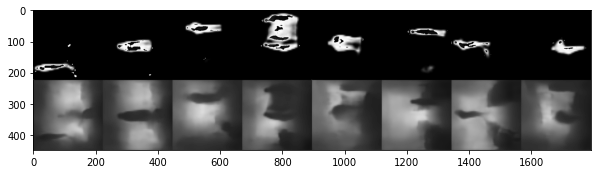

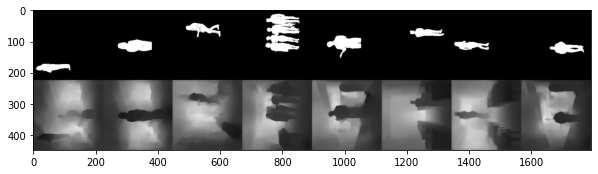

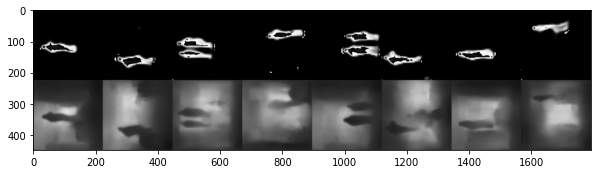

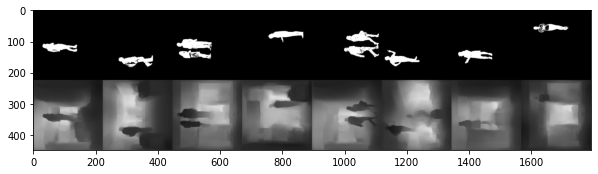

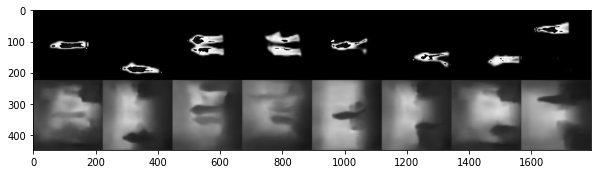

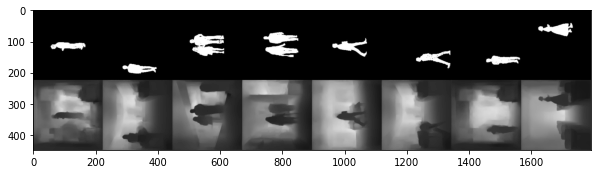

In [36]:
mmdtraintest.display_samples_new(expand_model, test_loader, device)

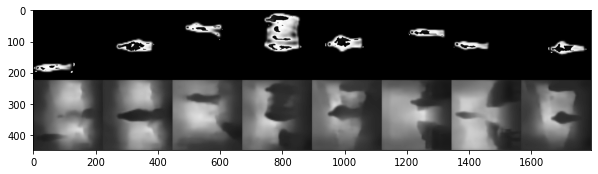

In [0]:
cmap='gray'
img = iter(test_loader).next()
with torch.no_grad():
    output_val = expand_model(img['input'].to(device)).to("cpu")
output_pred = torch.split(output_val,1,dim=1)
# mask_pred = [kornia.tensor_to_image(((output_pred[0][val].to("cpu")*0.0016620444341229432+0.057950844077600344)*255).byte()) for val in range(8) ]
# depth_pred = [kornia.tensor_to_image(((output_pred[1][val].to("cpu")*0.03551773442719045+0.3679109312239146)*255).byte()) for val in range(8) ]

mask_pred = [kornia.tensor_to_image((output_pred[0][val].to("cpu")*255).byte()) for val in range(8) ]
depth_pred = [kornia.tensor_to_image((output_pred[1][val].to("cpu")*255).byte()) for val in range(8) ]


img_shape = img['output'][0][1].shape[1]
mask_gt = [img['output'][0][val].reshape(img_shape,img_shape) for val in range(8) ]
depth_gt = [img['output'][1][val].reshape(img_shape,img_shape) for val in range(8) ]
plt.figure(figsize=(10,10)) 
plt.imshow(np.vstack([np.hstack(mask_pred),np.hstack(depth_pred)]),cmap=cmap)

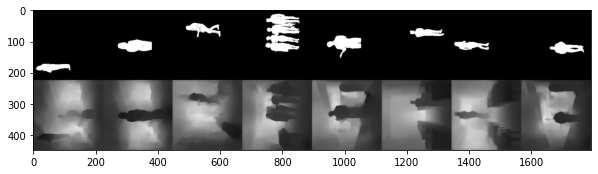

In [0]:
plt.figure(figsize=(10,10)) 

plt.imshow(np.vstack([np.hstack(mask_gt),np.hstack(depth_gt)]),cmap=cmap)

# Misc


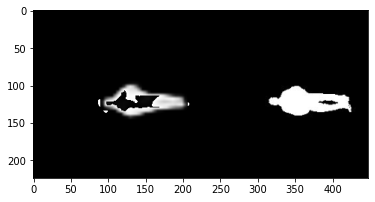

In [0]:
offset=7
plt.imshow(np.hstack([mask_pred[offset],mask_gt[offset]*255]), cmap=cmap)

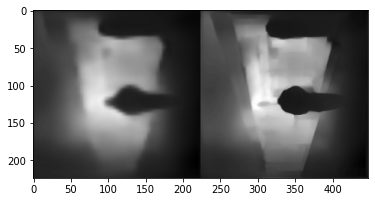

In [0]:
plt.imshow(np.hstack([depth_pred[offset],depth_gt[offset]*255]), cmap=cmap)
#plt.imshow(depth_pred[offset], cmap='gray')

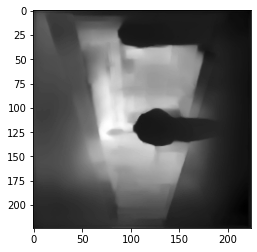

In [0]:
plt.imshow(depth_gt[offset]*255, cmap='gray')

In [0]:
torch.mean(mmdlosses.LocalL1Loss(img['output'][0][1], output_pred[0][1]))

tensor(12.1142)

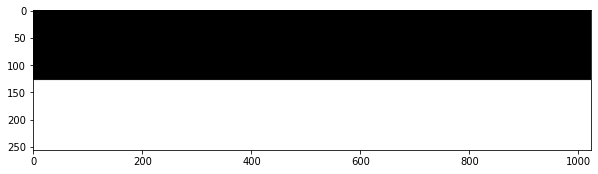

In [0]:
img = iter(train_loader).next()
with torch.no_grad():
    output_val = model_new(img['input'].to(device)).to("cpu")
output_pred = torch.split(output_val,1,dim=1)
# mask_pred = [kornia.tensor_to_image(((output_pred[0][val].to("cpu")*0.0016620444341229432+0.057950844077600344)*255).byte()) for val in range(8) ]
# depth_pred = [kornia.tensor_to_image(((output_pred[1][val].to("cpu")*0.03551773442719045+0.3679109312239146)*255).byte()) for val in range(8) ]

mask_pred = [kornia.tensor_to_image((output_pred[0][val].to("cpu")*255).byte()) for val in range(8) ]
depth_pred = [kornia.tensor_to_image((output_pred[1][val].to("cpu")*255).byte()) for val in range(8) ]


img_shape = img['output'][0][1].shape[1]
mask_gt = [img['output'][0][val].reshape(img_shape,img_shape) for val in range(8) ]
depth_gt = [img['output'][1][val].reshape(img_shape,img_shape) for val in range(8) ]
plt.figure(figsize=(10,10)) 
plt.imshow(np.vstack([np.hstack(mask_pred),np.hstack(depth_pred)]),cmap='gray')

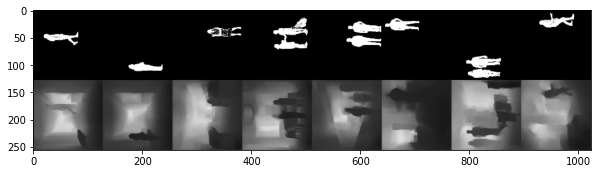

In [0]:
plt.figure(figsize=(10,10)) 
plt.imshow(np.vstack([np.hstack(mask_gt),np.hstack(depth_gt)]),cmap='gray')

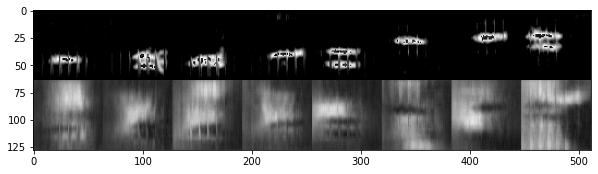

In [0]:
# plt.figure(figsize=(10,10)) 
plt.imshow(np.vstack([np.hstack(mask_pred),np.hstack(depth_pred)]),cmap='gray')

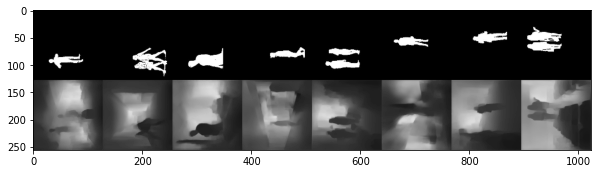

In [0]:
plt.figure(figsize=(10,10)) 
plt.imshow(np.vstack([np.hstack(mask_gt),np.hstack(depth_gt)]),cmap='gray')

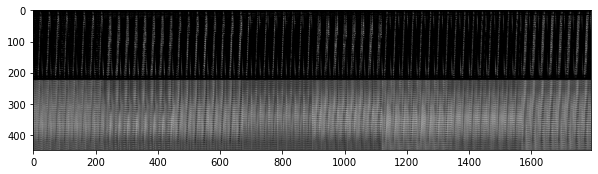

In [0]:
img = iter(train_loader_224).next()
with torch.no_grad():
    output_val = model_new(img['input'].to(device)).to("cpu")

output_pred = torch.split(output_val,1,dim=1)
mask_pred = [kornia.tensor_to_image((output_pred[0][val].to("cpu")*255).byte()) for val in range(8) ]
depth_pred = [kornia.tensor_to_image((output_pred[1][val].to("cpu")*255).byte()) for val in range(8) ]
mask_gt = [img['output'][0][val].reshape(224,224) for val in range(8) ]
depth_gt = [img['output'][1][val].reshape(224,224) for val in range(8) ]
plt.figure(figsize=(10,10)) 
plt.imshow(np.vstack([np.hstack(mask_pred),np.hstack(depth_pred)]),cmap='gray')


### bce_dice_with_rmse_ssim

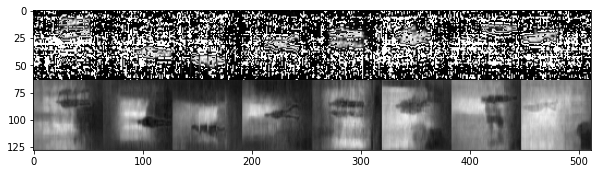

In [0]:
plt.figure(figsize=(10,10)) 
plt.imshow(np.vstack([np.hstack(mask_pred),np.hstack(depth_pred)]),cmap='gray')

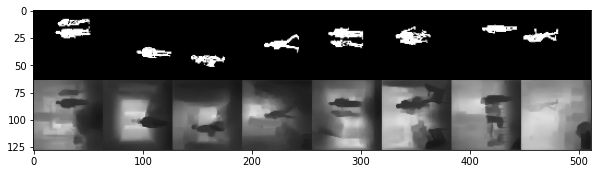

In [0]:
plt.figure(figsize=(10,10)) 
plt.imshow(np.vstack([np.hstack(mask_gt),np.hstack(depth_gt)]),cmap='gray')

In [0]:
plt.imshow(np.hstack([img['output'][1][offset].reshape(64,64),   depth_pred[offset]]),cmap='gray')

## bce_with_rmse

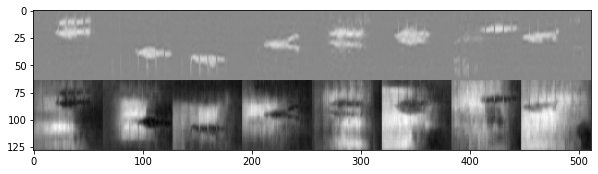

In [0]:
plt.figure(figsize=(10,10)) 
plt.imshow(np.vstack([np.hstack(mask_pred),np.hstack(depth_pred)]),cmap='gray')

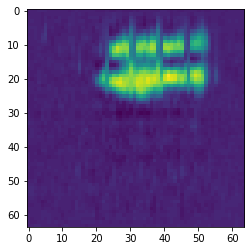

In [0]:
plt.imshow(mask_pred[0])

In [0]:
dice_loss(img['output'][0], output_pred[0])

tensor(0.8533)

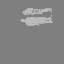

In [0]:
Image.fromarray(kornia.tensor_to_image(((torch.sigmoid(img['output'][0])*255).byte()[0])))

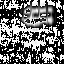

In [0]:
Image.fromarray(kornia.tensor_to_image(((output_pred[0]*255).byte()[0])))

In [0]:
Image.fromarray(kornia.tensor_to_image(((torch.sigmoid(output_pred[0])*255).byte()[0])))

In [0]:
kornia.losses.dice_loss((img['output'][0]*255), (output_pred[0]*255))

In [0]:
output_pred[0].shape

torch.Size([64, 1, 64, 64])

In [0]:
dice_loss(img['output'][0][0], output_pred[0][0])

tensor(0.8170)

In [0]:
def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.
    
    iflat = input.view(-1)
    tflat = target.contiguous().view(-1)#reshape(64*64*64)
    #target.view(-1)
    intersection = (iflat * tflat).sum()
    
    return 1 - ((2. * intersection + smooth) /
              (iflat.sum() + tflat.sum() + smooth))

In [0]:
nn.BCEWithLogitsLoss()(img['output'][0], output_pred[0])

tensor(0.6849)

In [0]:
len(mask_pred)

8

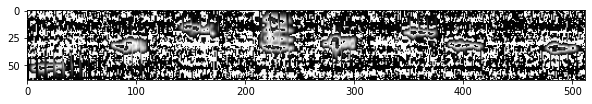

In [0]:
#Image.fromarray(kornia.tensor_to_image((mask_pred*255).byte())),
plt.figure(figsize=(10,10)) 
plt.imshow(np.hstack(mask_pred),cmap='gray')

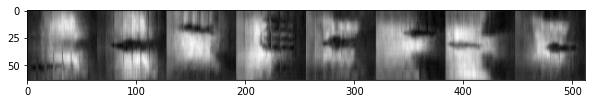

In [0]:
#Image.fromarray(kornia.tensor_to_image((mask_pred*255).byte())),
plt.figure(figsize=(10,10)) 
plt.imshow(np.hstack(depth_pred),cmap='gray')#

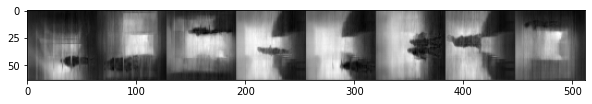

In [0]:


Image.fromarray(kornia.tensor_to_image((mask_pred*255).byte())),
plt.figure(figsize=(10,10)) 
plt.imshow(np.hstack(depth_pred),cmap='gray')#

In [0]:
!pip install kornia

     |████████████████████████████████| 163kB 6.0MB/s 


In [0]:
for zip(img['input'][0],img['input'][1])

In [0]:
np.concatenate((img['input'][0][0].numpy(),img['input'][0][1].numpy()), axis=2).shape

(250, 250, 6)

In [0]:
 
pbar = tqdm(depth_dataset)

#bg_mean = np.zeros((4,3))
n, mean, M2 = (0.0,0.0,0.0)
for i_batch,img in enumerate(pbar):
    #img = depth_dataset[i_batch]
    #img_mean = np.mean(img, axis=(0,1))
    img_mean = np.array([ np.mean(iter_val/255.0,axis=(0,1)) for left_k,right_v in img.items() for iter_val in right_v ])
    n, mean, M2 = update_mean_variance((n, mean, M2), img_mean)

print(finalize_mean_variance(n, mean, M2))

In [0]:
# hf = h5py.File('data7.h5', 'w')
# #base_zip = ZipFile('/content/image_mask_gt2k6k.zip')
# #pbar = tqdm(depth_dataset)
# #hf.close()
# def hf_create_dataset(hdf_file, file_name, data):
#     hdf_file.create_dataset(
#                 name=file_name,
#                 data=data,
#                 compression="gzip", compression_opts=9
#                 )
# i_batch=0
# #for i_batch,img in enumerate(pbar):
# start = time.process_time()
# #try:
# for img in depth_dataset:
#     #key_name = 
#     if(i_batch > 100000):
#         break
#     #val_arr = [iter_val 
#     for left_k,right_v in img.items():
#         for inner_k, iter_val in right_v.items():
#             #print(inner_k)
#             hf_create_dataset(hf, inner_k ,iter_val)

#     if(i_batch % 1000 == 0 and i_batch > 1000):
#         current = time.process_time()
#         print("No:of records processed:{} Time Elapsed:{}".format(i_batch, current-start))
#     i_batch += 1

# end = time.process_time()
# print("No:of records processed:{} Time Elapsed:{}".format(i_batch, end-start))
# #except:

# #    hf.close()

In [0]:
from google.colab import auth
auth.authenticate_user()

In [0]:
from googleapiclient.discovery import build
gcs_service = build('storage', 'v1')

In [0]:
import uuid
bucket_name = 'colab-sample-bucket-' + str(uuid.uuid1())

body = {
  'name': bucket_name,
  # For a full list of locations, see:
  # https://cloud.google.com/storage/docs/bucket-locations
  'location': 'us',
}
gcs_service.buckets().insert(project=project_id, body=body).execute()
print('Done')

In [0]:
hf.close()

In [0]:
hf_read = h5py.File('data7.h5', 'r')

In [0]:
hf_read.keys()

<KeysViewHDF5 ['depth_image_023aa22186_classroom_1.jpg', 'depth_image_0ccf0b6adb_classroom_8.jpg', 'depth_image_0d06379c4e_classroom_12.jpg', 'depth_image_100078863e_classroom_10.jpg', 'depth_image_1000d68e48_classroom_2.jpg', 'depth_image_10023ed777_classroom_12.jpg', 'depth_image_10027aa3fa_classroom_4.jpg', 'depth_image_1002953763_classroom_1.jpg', 'depth_image_1002a448f4_classroom_10.jpg', 'depth_image_1002be3508_classroom_3.jpg', 'depth_image_1002e52563_classroom_14.jpg', 'depth_image_1002e75f62_classroom_15.jpg', 'depth_image_100317e99d_classroom_14.jpg', 'depth_image_1003212d72_classroom_8.jpg', 'depth_image_10033c4a69_classroom_8.jpg', 'depth_image_10038181d7_classroom_3.jpg', 'depth_image_1003ffcca2_classroom_10.jpg', 'depth_image_1004993b2d_classroom_13.jpg', 'depth_image_1004dd5dd3_classroom_16.jpg', 'depth_image_100659c8dd_classroom_17.jpg', 'depth_image_1006609a43_classroom_16.jpg', 'depth_image_10074a3520_classroom_8.jpg', 'depth_image_1007f75489_classroom_8.jpg', 'depth_

In [0]:
### Knuth/Welford algorithm to generate mean by addition of new samples to existing mean

def update_mean_variance(existingAggregate, newValue):
    (count, mean, M2) = existingAggregate
    count += 1
    delta = newValue - mean
    mean += delta / count
    delta2 = newValue - mean
    M2 += delta * delta2

    return (count, mean, M2)

# Retrieve the mean, variance and sample variance from an aggregate
def finalize_mean_variance(existingAggregate):
    (count, mean, M2) = existingAggregate
    if count < 2:
        return float('nan')
    else:
       (mean, variance, sampleVariance) = (mean, M2 / count, M2 / (count - 1))
       return (mean, variance, sampleVariance)

In [0]:
calc_mean,variance, _ = finalize_mean_variance((n, mean, M2))
print(calc_mean)
print(np.sqrt(variance))

[[0.56632738 0.51567622 0.45670792]
 [0.57469445 0.52241555 0.45992244]
 [0.05795104 0.05795104 0.05795104]
 [0.61635181 0.21432114 0.50569604]]
[[0.1076622  0.10650349 0.12808967]
 [0.11322354 0.11195428 0.13441683]
 [0.02640032 0.02640032 0.02640032]
 [0.09193359 0.07619106 0.04919082]]


In [0]:
#depth_map = np.hstack([depth_dataset[index_val]['output'][1] for index_val in myrandom_array])
depth_map = [depth_dataset[index_val]['output'][1] for index_val in myrandom_array]
mask_image = [depth_dataset[index_val]['output'][0] for index_val in myrandom_array]
bg_image = [depth_dataset[index_val]['input'][1] for index_val in myrandom_array]
fg_bg_image = [depth_dataset[index_val]['input'][0] for index_val in myrandom_array]
final_list = np.hstack([ mask_image, bg_image, fg_bg_image])

In [0]:
from matplotlib import pyplot as plt

In [0]:
plt.figure(figsize=(24,32))
plt.imshow(depth_map,cmap='gray')

In [0]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

fig = plt.figure(figsize=(100., 100.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 20),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
for ax, im in zip(grid, depth_map):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

plt.show()

In [0]:
plt.savefig('/content/drive/My Drive/EVA4/tsai/S15EVA4/depthmaptile.png')

<Figure size 432x288 with 0 Axes>

In [0]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

fig = plt.figure(figsize=(100., 100.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(3, 20),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
for ax, im in zip(grid, final_list):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

plt.show()

In [0]:
Image.fromarray(depth_dataset[0]['output'][0])

In [0]:
Image.fromarray(depth_dataset[0]['output'][1])

In [0]:
import glob
fileList = [file_name for file_name in glob.glob('/content/drive/My Drive/EVA4/tsai/S15EVA4/people_cropresize/*png')]
print("Number of images of people:{}".format(len(fileList)))

Number of images of people:110


In [0]:
import os

for file_name in fileList:
    image_name = os.path.basename(file_name)
    my_array = np.array(Image.open(file_name))
    print("FileName: {} Shape:{}".format(image_name, my_array.shape))

In [0]:
base_dir = '/content/drive/My Drive/EVA4/tsai/S15EVA4/people_cropresize/'
aug_path = '/content/drive/My Drive/EVA4/tsai/S15EVA4/people_cropresize/aug_images'
image_list = [ ]


for file_name in glob.glob(base_dir+"/*png")[:20]:
    basefile_name = os.path.basename(file_name)
    #print(basefile_name)
    mask_name = os.path.join(aug_path,"mask_"+basefile_name)
    flip_name = os.path.join(aug_path,"flip_"+basefile_name)
    flip_mask_name = os.path.join(aug_path,"mask_"+os.path.basename(flip_name))
    print(file_name,mask_name,flip_name,  flip_mask_name)
    image_list.append([np.array(Image.open(val)) for val in [file_name,mask_name,flip_name,  flip_mask_name ]])

In [0]:
for val in image_list:
    plt.imshow(np.hstack([val[0],val[2]]))
    plt.imshow(np.hstack([val[1],val[3]]))

In [0]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
#for iter in image_list:
for ax, im in zip(grid, image_list[2]):
    #print(ax., )
    # Iterating over the grid returns the Axes.
    ax.imshow(im, cmap='gray')

In [0]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

In [0]:
model = ResNet50(weights='imagenet')

102973440/102967424 [==============================] - 1s 0us/step


In [0]:
model.summary()

In [0]:
#csv_file = '/content/drive/My Drive/EVA4/tsai/S15EVA4/DepthMapDataSetSample.csv'
batch_start = 90000
batch_end = batch_start+30000

test_batch_start = 512
test_batch_end = test_batch_start + 1512
csv_file ='/content/drive/My Drive/EVA4/tsai/S15EVA4/FinalDataSet/DepthMapDataSetTrain.csv'
root_dir = '/content/drive/My Drive/EVA4/tsai/S15EVA4/'
size_hw = (128,128)
depth_dataset = mmddataloader.DepthMaskDataSet(csv_file, root_dir, batch_start,batch_end, read_zip=True,
                                 transform_base=mmddataloader.resize_bg(size_hw[0],size_hw[1],[0.56632738, 0.51567622, 0.45670792], [0.1076622, 0.10650349, 0.12808967] ),
                                 transform_bg=mmddataloader.resize_bg(size_hw[0],size_hw[1],[0.57469445, 0.52241555, 0.45992244], [0.11322354, 0.11195428, 0.13441683]),
                                  transform_mask = mmddataloader.resize_bg_nonNorm(size_hw[0],size_hw[1]),
                                  transform_depth = mmddataloader.resize_bg_nonNorm(size_hw[0],size_hw[1]),
                                 #transform_mask=mmddataloader.resize_bg(size_hw[0],size_hw[1], [0.0579508], [0.001662]),
                                 #transform_depth=mmddataloader.resize_bg(size_hw[0],size_hw[1], [0.3679109], [0.03551773]),
                                 )
from torch.utils.data import DataLoader
kwargs= { 'num_workers':1,'pin_memory': True}
train_loader = DataLoader(depth_dataset, batch_size=64, shuffle=False, **kwargs)

test_dataset = mmddataloader.DepthMaskDataSet(csv_file, root_dir, test_batch_start,test_batch_end,read_zip=True,
                                 transform_base=mmddataloader.resize_bg(size_hw[0],size_hw[1],[0.56632738, 0.51567622, 0.45670792], [0.1076622, 0.10650349, 0.12808967] ),
                                 transform_bg=mmddataloader.resize_bg(size_hw[0],size_hw[1],[0.57469445, 0.52241555, 0.45992244], [0.11322354, 0.11195428, 0.13441683]),
                                 transform_mask = mmddataloader.resize_bg_nonNorm(size_hw[0],size_hw[1]),
                                 transform_depth = mmddataloader.resize_bg_nonNorm(size_hw[0],size_hw[1]),
                                 #transform_mask=mmddataloader.resize_bg(size_hw[0],size_hw[1], [0.0579508], [0.001662]),
                                 #transform_depth=mmddataloader.resize_bg(size_hw[0],size_hw[1], [0.3679109], [0.03551773]),
                                 )
from torch.utils.data import DataLoader
kwargs= { 'num_workers':1,'pin_memory': True}
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, **kwargs)